In [1]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev==2.3.29
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 852.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from pathlib import Path

def plot_label_counts(dls):
    # Inicializar listas para etiquetas de training (originales y destiladas)
    train_original_labels = []
    train_distilled_labels = []

    # Recorrer cada ejemplo en el dataset de training
    for i in range(len(dls.train_ds)):
        label = int(dls.train_ds[i][1])
        # Obtener la ruta del archivo y extraer el nombre
        path = Path(dls.train_ds.items[i])
        filename = path.name.lower()  # convertir a minúsculas para evitar problemas con mayúsculas

        # Clasificar: si el nombre comienza con 'distilled', es destilado; de lo contrario, es original.
        if filename.startswith("distilled"):
            train_distilled_labels.append(label)
        else:
            train_original_labels.append(label)

    # Para validación, todas las imágenes se consideran originales
    valid_labels = [int(dls.valid_ds[i][1]) for i in range(len(dls.valid_ds))]

    # Contar el número de ejemplos por etiqueta en cada grupo
    train_orig_counts = Counter(train_original_labels)
    train_dist_counts = Counter(train_distilled_labels)
    valid_counts = Counter(valid_labels)

    # Obtenemos el vocabulario (lista de nombres de clases) y el número de clases:
    vocab = dls.vocab
    n_classes = len(vocab)

    # Crear listas de conteos para cada clase (asumiendo índices de 0 a n_classes-1)
    orig_data = [train_orig_counts[i] for i in range(n_classes)]
    dist_data = [train_dist_counts[i] for i in range(n_classes)]
    valid_data = [valid_counts[i] for i in range(n_classes)]

    # Configurar el gráfico de barras agrupadas:
    x = np.arange(n_classes)
    width = 0.25  # ancho de cada barra, para acomodar tres barras por etiqueta

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x - width, orig_data, width, label='Train Original', color='blue')
    ax.bar(x, dist_data, width, label='Train Distilled', color='red')
    ax.bar(x + width, valid_data, width, label='Valid', color='yellow')

    ax.set_ylabel('Número de elementos')
    ax.set_xticks(x)
    ax.set_xticklabels(vocab)
    ax.legend()

    plt.show()


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Apartado 1

In [5]:
import os
import shutil
from pathlib import Path
from torchvision import datasets
from fastai.vision.all import *
import torch.nn as nn
import torch
from PIL import Image

# 1. Configurar FASTAI_HOME y definir rutas base
os.environ["FASTAI_HOME"] = str(Path('/content/dataset'))

base_path = Path('/content/dataset')
fashion_path = base_path / "fashion_mnist"  # Ruta donde se descargará FashionMNIST

# 2. Descargar FashionMNIST con torchvision (se obtienen imágenes PIL al usar transform=None)
train_dataset = datasets.FashionMNIST(root=str(fashion_path), train=True, download=True)
test_dataset  = datasets.FashionMNIST(root=str(fashion_path), train=False, download=True)

# 3. Definir la estructura de carpetas destino: /content/dataset/original/fashion_mnist/{train,test}/{clase}/imagen.png
dest_base   = base_path / "original" / "fashion_mnist"
train_folder = dest_base / "train"
test_folder  = dest_base / "test"

train_folder.mkdir(parents=True, exist_ok=True)
test_folder.mkdir(parents=True, exist_ok=True)

# Obtener los nombres de clases del dataset (por ejemplo: 'T-shirt/top', 'Trouser', etc.)
classes = train_dataset.classes

for idx, (img, label) in enumerate(train_dataset):
    label_name = classes[label]
    out_dir = train_folder / label_name
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f"{idx}.png"
    img.save(out_file)

# Guardar imágenes de test organizadas en carpetas por clase
for idx, (img, label) in enumerate(test_dataset):
    label_name = classes[label]
    out_dir = test_folder / label_name
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f"{idx}.png"
    img.save(out_file)


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 169kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.09MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.8MB/s]


## Lenet

In [6]:
dataset_root = train_folder

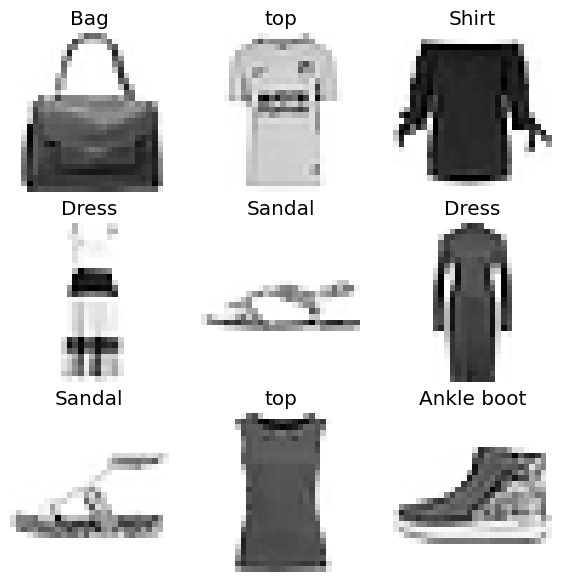

In [ ]:
# Creamos el DataBlock
blocks = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Generar DataLoaders a partir de la ruta indicada
dls = blocks.dataloaders(dataset_root, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 48000
Número total de imágenes en validación: 12000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser', 'top']


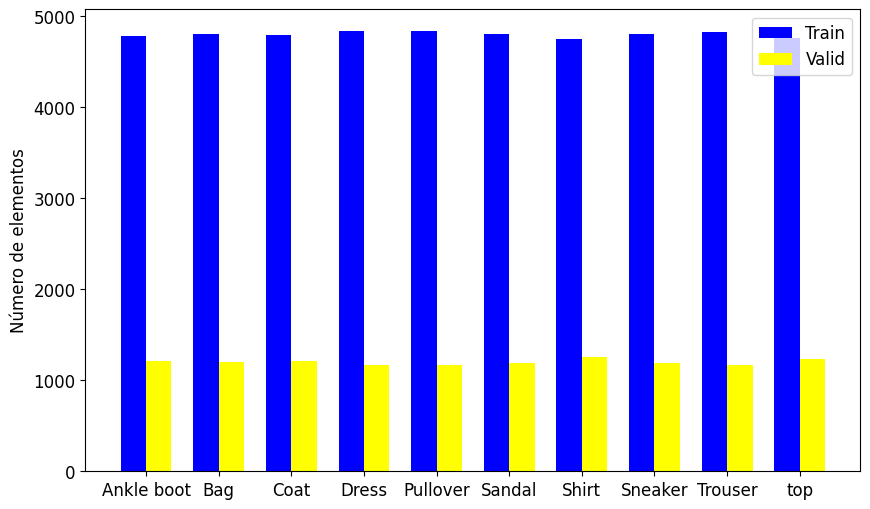

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [7]:
import torch.nn.functional as F

class LeNet(nn.Module):
  def __init__(self, num_classes=10):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)  # Aplanar la salida
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

learn.summary()

LeNet (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 6 x 24 x 24    
Conv2d                                    156        True      
____________________________________________________________________________
                     64 x 16 x 8 x 8     
Conv2d                                    2416       True      
____________________________________________________________________________
                     64 x 16 x 4 x 4     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 120            
Linear                                    30840      True      
____________________________________________________________________________
                     64 x 84             
Linear                                    10164      True      
____________________________________________________________

In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.990850,0.926572,0.660167,0.659593,0.632148,00:49
1,0.702241,0.668015,0.743667,0.745161,0.740910,00:56
2,0.587358,0.551684,0.797833,0.798082,0.800327,00:56
3,0.489490,0.442250,0.838500,0.839896,0.834927,00:52
4,0.409349,0.411631,0.848083,0.848377,0.845425,01:00
5,0.365879,0.350401,0.871917,0.873145,0.870094,00:53
6,0.347408,0.333913,0.878833,0.879807,0.876175,01:03
7,0.330379,0.327646,0.878333,0.878844,0.880353,00:53
8,0.294371,0.296789,0.890667,0.891081,0.891561,00:54
9,0.278894,0.295047,0.890167,0.890752,0.891445,00:54



Tiempo de entrenamiento: 1113.23 segundos


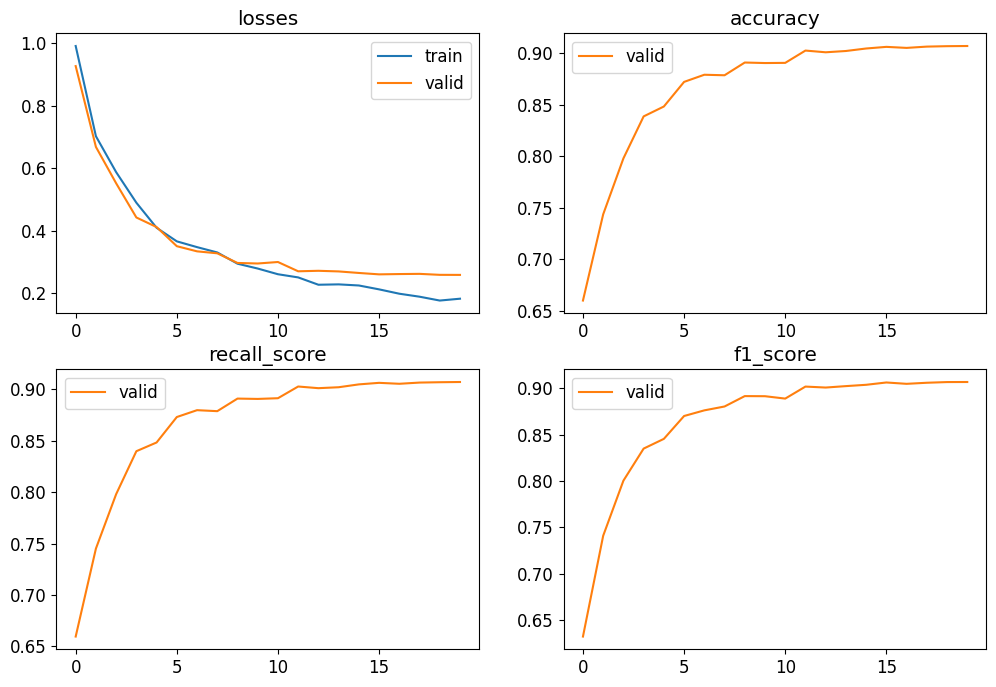

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2586
Accuracy: 0.9067
Recall: 0.9072
F1-Score: 0.9068


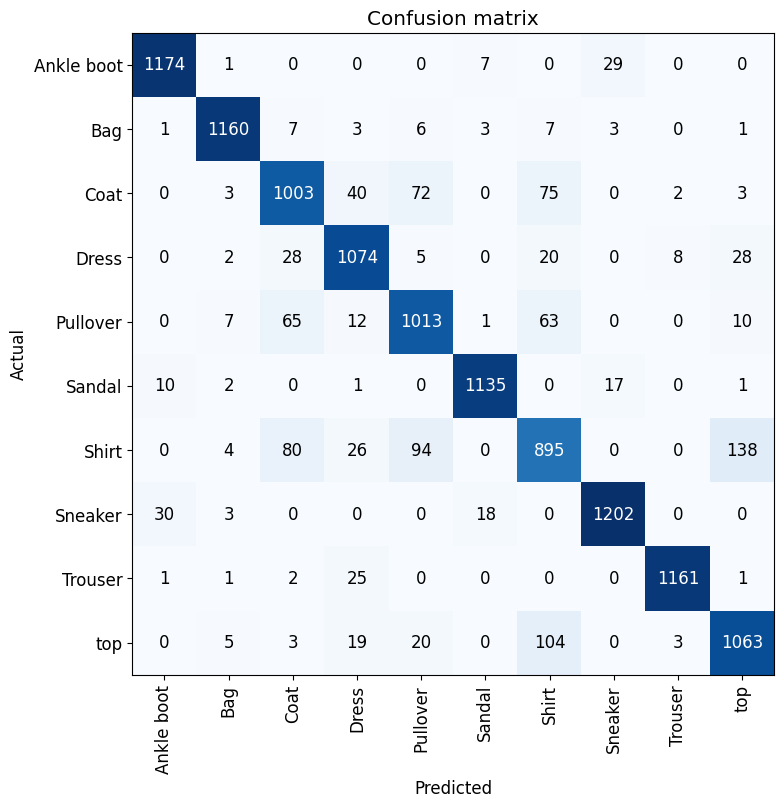

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_original_v3.pkl')

## Resnet

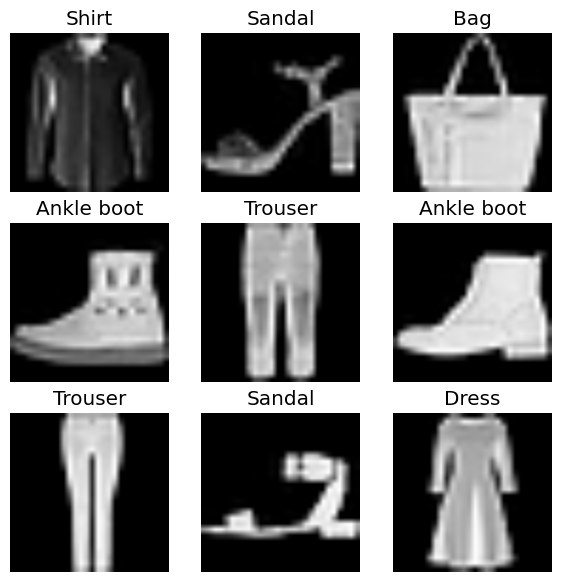

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

dls = dblock.dataloaders(dataset_root, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
# Crear el learner con resnet18
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
# Entrenar el modelo
start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.638159,0.482347,0.829417,0.828009,0.827193,03:32
1,0.473046,0.395655,0.856917,0.856307,0.855928,03:28
2,0.373110,0.333889,0.872250,0.872053,0.867380,03:28
3,0.316721,0.306195,0.890583,0.889874,0.890993,03:28
4,0.267673,0.237970,0.915167,0.914547,0.913339,03:28
5,0.247592,0.233786,0.915833,0.915050,0.915372,03:27
6,0.220836,0.207168,0.924750,0.924253,0.923923,03:28
7,0.196748,0.205336,0.928417,0.927955,0.927450,03:28
8,0.166748,0.187464,0.934667,0.934082,0.933635,03:30
9,0.152017,0.205479,0.929917,0.929057,0.929680,03:28


No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 2927.82 segundos


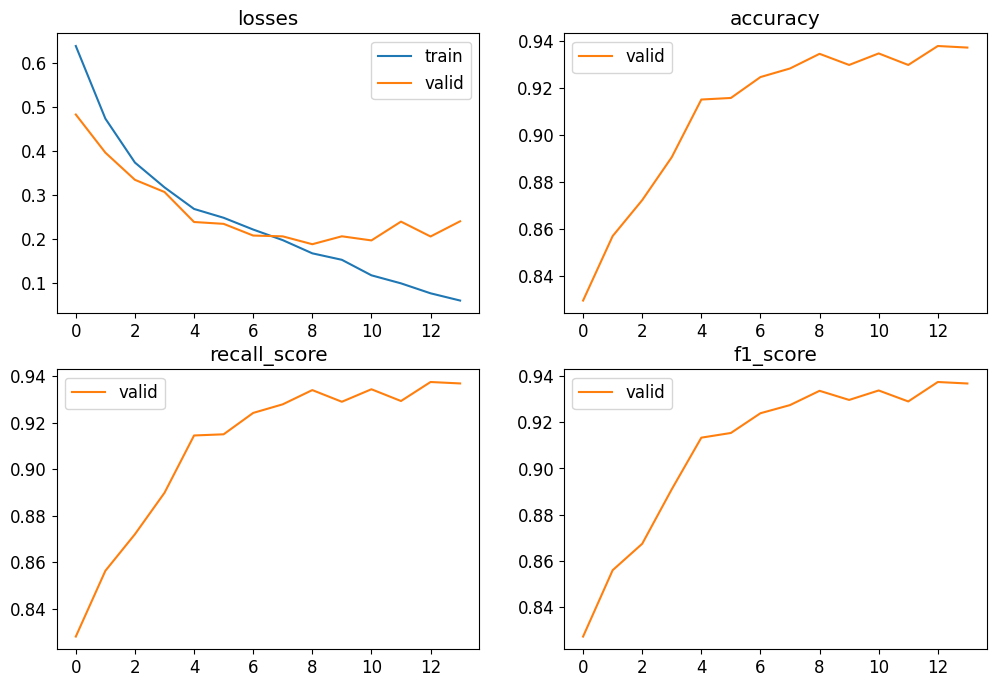

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2396
Accuracy: 0.9373
Recall: 0.9369
F1-Score: 0.9368


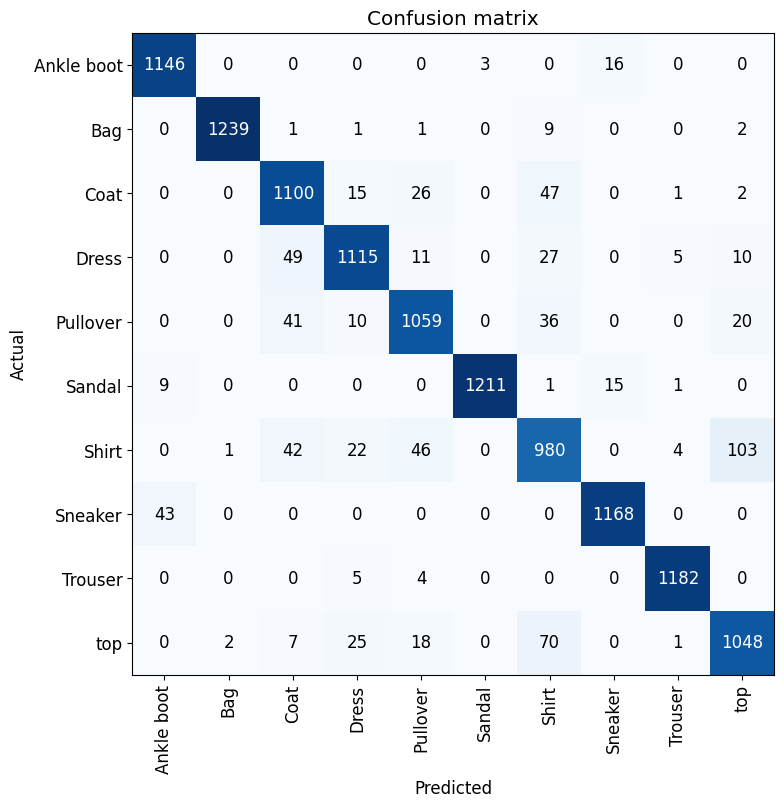

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_original_v3.pkl')

# Apartado 2

## Destilacion de datos

In [ ]:
import random
import shutil
from pathlib import Path
import numpy as np
from PIL import Image

def media_arit(image_paths):
    avg_image = None
    count = 0
    # Sumar todas las imágenes (convertidas a array NumPy)
    for img_path in image_paths:
        with Image.open(img_path) as img:
            np_img = np.array(img, dtype=np.float32)
            if avg_image is None:
                avg_image = np_img
            else:
                avg_image += np_img
            count += 1
    # Calcular la media y convertir a uint8
    avg_image /= count
    avg_image = np.clip(avg_image, 0, 255).astype(np.uint8)
    return Image.fromarray(avg_image, mode='L')


In [ ]:
def create_partial_distilled(src_path, dst_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=1, mix_function=media_arit):
    """
    Crea un nuevo dataset a partir de src_path con la siguiente estrategia:

      - Se divide en 80% training y 20% validación (valid_ratio).
      - En el conjunto de training:
          * El 80% de las imágenes se procesan mediante destilación usando mix_function.
          * El 20% restante se copia sin modificar.
      - En el conjunto de validación se copian las imágenes sin modificaciones.

    Parámetros:
      src_path: Ruta a la carpeta original, que debe tener subcarpetas para cada clase.
      dst_path: Ruta destino para el nuevo dataset.
      valid_ratio: Proporción de imágenes para validación (ej. 0.2 para 20%).
      distilled_portion: Proporción de imágenes dentro del training que serán destiladas (ej. 0.8 para 80%).
      group_fraction:
          * Si es 1, se mezclan todas las imágenes del subconjunto de destilación en una sola imagen.
          * Si es un valor entre 0 y 1, se agrupan en bloques cuyo tamaño es group_size = int(len(distilled_images) * group_fraction).
          * Si es 0, se procesa cada imagen individualmente (aunque normalmente querrás usar 1 o un valor intermedio).
      mix_function: Función que recibe una lista de rutas de imágenes y devuelve una imagen destilada.
    """
    src_path = Path(src_path)
    dst_path = Path(dst_path)

    # Eliminar dst_path si ya existe
    if dst_path.exists():
        shutil.rmtree(dst_path)
    dst_path.mkdir(parents=True, exist_ok=True)

    # Crear directorios para training y validación
    train_dst = dst_path / "training"
    valid_dst = dst_path / "valid"
    train_dst.mkdir(parents=True, exist_ok=True)
    valid_dst.mkdir(parents=True, exist_ok=True)

    # Procesar cada subcarpeta (clase) en src_path
    for class_dir in src_path.iterdir():
        if not class_dir.is_dir():
            continue

        if class_dir.name.lower() == "t-shirt":
            images = list(class_dir.glob('**/*.*'))
        else:
            images = list(class_dir.glob('*.*'))
        if not images:
            continue

        # Barajar y separar en training y validación
        random.shuffle(images)
        total = len(images)
        n_valid = int(total * valid_ratio)
        n_train = total - n_valid

        train_images = images[:n_train]
        valid_images = images[n_train:]

        # Dentro de training, separar el 80% para destilación y el 20% para copiar sin modificar
        n_train_distilled = int(n_train * distilled_portion)
        n_train_original = n_train - n_train_distilled

        distilled_images = train_images[:n_train_distilled]
        original_train_images = train_images[n_train_distilled:]

        # Crear subdirectorios para la clase en training y validación
        new_train_class_dir = train_dst / class_dir.name
        new_train_class_dir.mkdir(parents=True, exist_ok=True)
        new_valid_class_dir = valid_dst / class_dir.name
        new_valid_class_dir.mkdir(parents=True, exist_ok=True)

        # Procesar las imágenes para destilación (80% del conjunto de training)
        if group_fraction == 0:
            # Procesar cada imagen individualmente (aunque esto normalmente no es lo esperado)
            for img_path in distilled_images:
                distilled_img = mix_function([img_path])
                # Se guarda con el mismo nombre original
                new_file = new_train_class_dir / img_path.name
                distilled_img.save(new_file)
        elif group_fraction == 1:
            # Mezclar todas las imágenes del subconjunto en una sola imagen destilada
            distilled_img = mix_function(distilled_images)
            distilled_filename = new_train_class_dir / "distilled.jpg"
            distilled_img.save(distilled_filename)
        else:
            # Agrupar las imágenes en bloques
            group_size = max(1, int(len(distilled_images) * group_fraction))
            group_count = 0
            for i in range(0, len(distilled_images), group_size):
                group = distilled_images[i:i + group_size]
                distilled_img = mix_function(group)
                distilled_filename = new_train_class_dir / f"distilled_{group_count}.jpg"
                distilled_img.save(distilled_filename)
                group_count += 1

        # Copiar las imágenes originales (20% de training) sin modificar
        for img_path in original_train_images:
            shutil.copy(img_path, new_train_class_dir)

        # En validación se copian todas las imágenes sin procesar
        for img_path in valid_images:
            shutil.copy(img_path, new_valid_class_dir)


In [ ]:
original_path = Path('/content/dataset/original/fashion_mnist/train')

mnist_001_path = base_path / "distilled_001"
mnist_001_path.mkdir(parents=True, exist_ok=True)

mnist_005_path = base_path / "distilled_005"
mnist_005_path.mkdir(parents=True, exist_ok=True)

mnist_0001_path = base_path / "distilled_0001"
mnist_0001_path.mkdir(parents=True, exist_ok=True)

In [ ]:
create_partial_distilled(original_path, mnist_001_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.01, mix_function=media_arit)

In [ ]:
create_partial_distilled(original_path, mnist_005_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.05, mix_function=media_arit)

In [ ]:
create_partial_distilled(original_path, mnist_0001_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.001, mix_function=media_arit)

Total de ejemplos: 60,000

División Train/Test: 80% (Train) - 20% (Test):
- Cantidad en Train: 80% de 60,000 = 48,000 ejemplos
- Cantidad en Test: 20% de 60,000 = 12,000 ejemplos

Dentro de Train:
- 80% se destilan → 80% de 48,000 = 38,400 que se destilan al x%
- 20% se mantienen intactos → 20% de 48,000 = 9,600 ejemplos originales


Suponiendo que x = 1%:
- tenemos 100 + 9,600 = 9,700 aproximadamente


## Lenet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

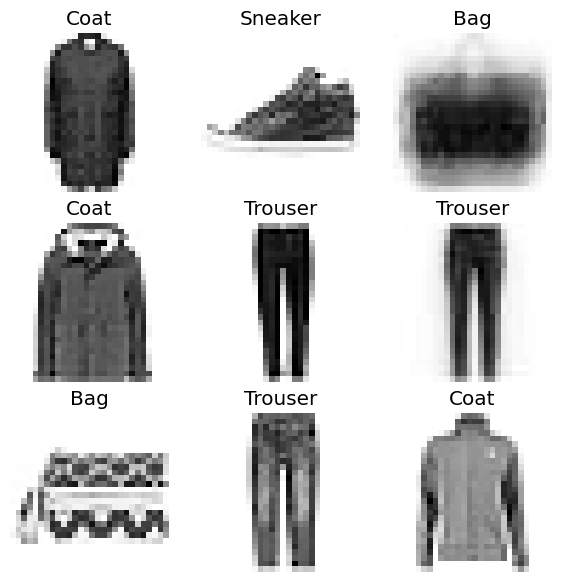

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 9558
Número total de imágenes en validación: 10800

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser']


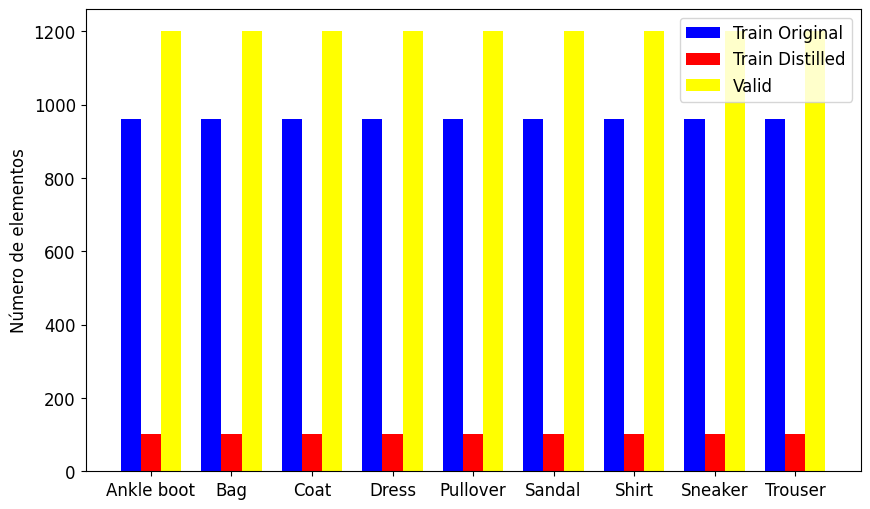

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.265462,2.236711,0.334722,0.334722,0.246941,00:27
1,1.646266,1.238787,0.562222,0.562222,0.513409,00:24
2,0.849389,0.790317,0.682870,0.682870,0.668870,00:16
3,0.729298,0.711680,0.717130,0.717130,0.701393,00:16
4,0.656493,0.765387,0.708241,0.708241,0.680124,00:16
5,0.602875,0.666142,0.731481,0.731481,0.707936,00:17
6,0.565532,0.593504,0.771852,0.771852,0.765775,00:17
7,0.517423,0.521804,0.797963,0.797963,0.790120,00:16
8,0.485596,0.533535,0.789722,0.789722,0.785016,00:16
9,0.452369,0.474710,0.819352,0.819352,0.816876,00:16


No improvement since epoch 24: early stopping

Tiempo de entrenamiento: 484.59 segundos


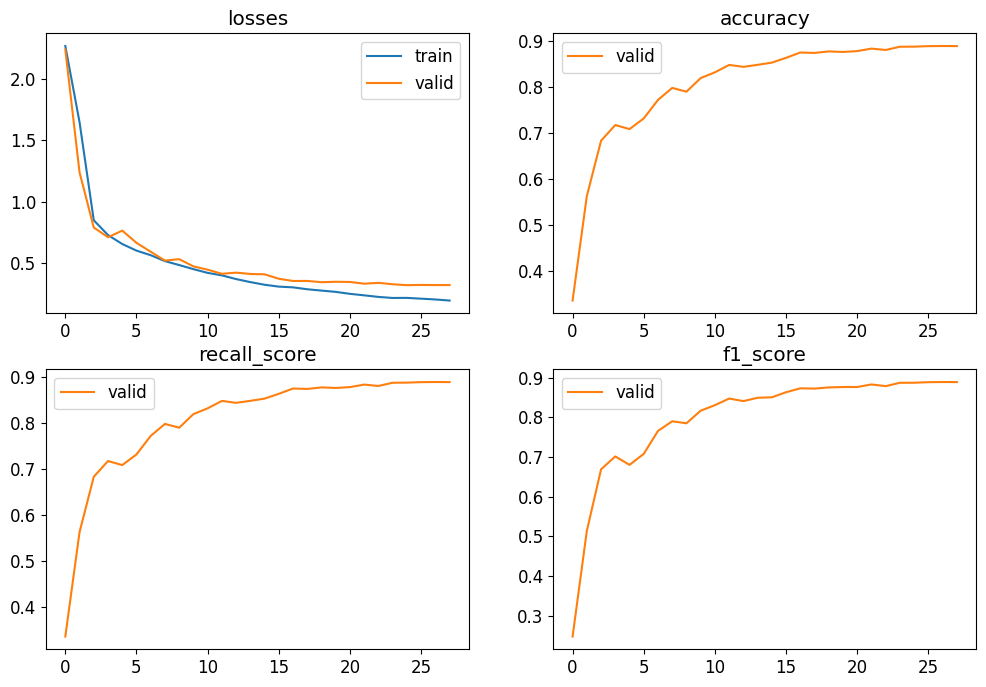

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3230
Accuracy: 0.8891
Recall: 0.8891
F1-Score: 0.8890


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster01_v4.pkl')

Example 2

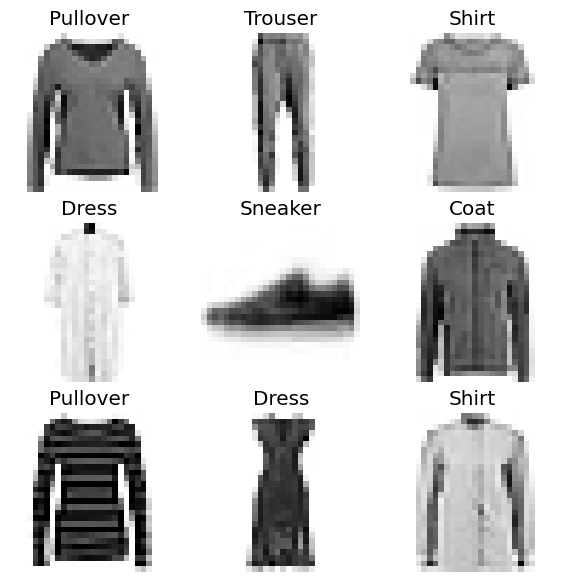

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.243600,2.151254,0.161111,0.161111,0.079660,00:16
1,1.110459,0.834258,0.668611,0.668611,0.651017,00:17
2,0.747608,0.723442,0.711852,0.711852,0.712824,00:20
3,0.657348,0.670335,0.715648,0.715648,0.708549,00:27
4,0.610271,0.607580,0.760926,0.760926,0.756797,00:23
5,0.568548,0.575276,0.782778,0.782778,0.778298,00:16
6,0.504848,0.534917,0.795833,0.795833,0.789555,00:16
7,0.485504,0.525072,0.795185,0.795185,0.790129,00:16
8,0.447008,0.467944,0.829815,0.829815,0.828446,00:16
9,0.420148,0.474837,0.818796,0.818796,0.817564,00:17



Tiempo de entrenamiento: 355.98 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3700
Accuracy: 0.8693
Recall: 0.8693
F1-Score: 0.8688


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster03_v4.pkl')

## Lenet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

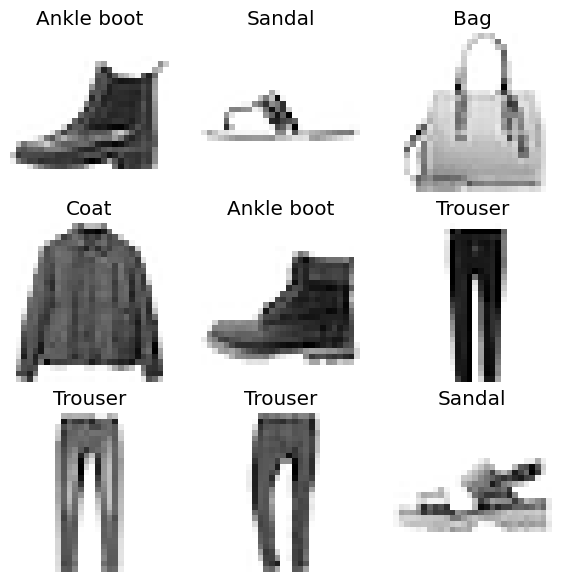

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 8820
Número total de imágenes en validación: 10800

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser']


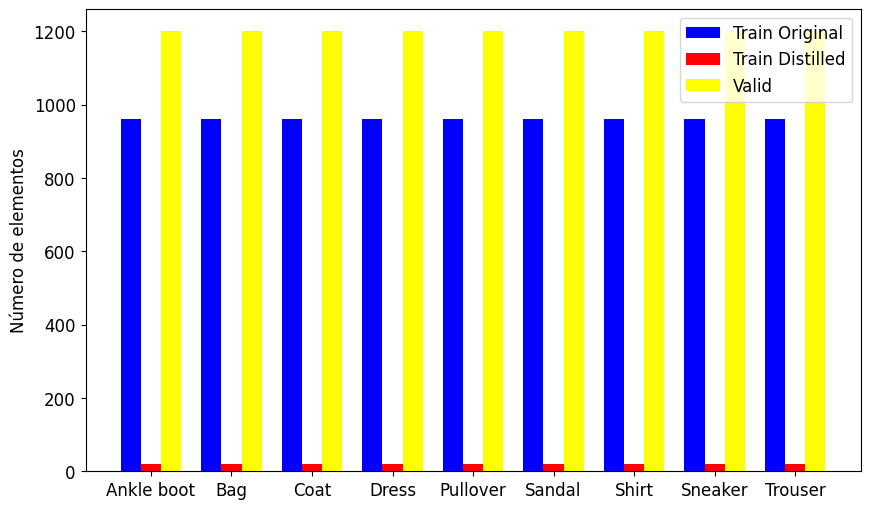

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.277054,2.256490,0.141759,0.141759,0.053010,00:15
1,1.893241,1.519302,0.487407,0.487407,0.425531,00:15
2,1.030801,0.869807,0.658333,0.658333,0.646040,00:15
3,0.800161,0.741512,0.702870,0.702870,0.693442,00:16
4,0.726777,0.674863,0.730926,0.730926,0.730826,00:16
5,0.669072,0.659687,0.723611,0.723611,0.711139,00:15
6,0.612735,0.630165,0.728333,0.728333,0.708838,00:15
7,0.589862,0.564719,0.775278,0.775278,0.770099,00:15
8,0.560906,0.529945,0.796111,0.796111,0.793257,00:25
9,0.524395,0.532957,0.795093,0.795093,0.789918,00:22


No improvement since epoch 32: early stopping

Tiempo de entrenamiento: 597.95 segundos


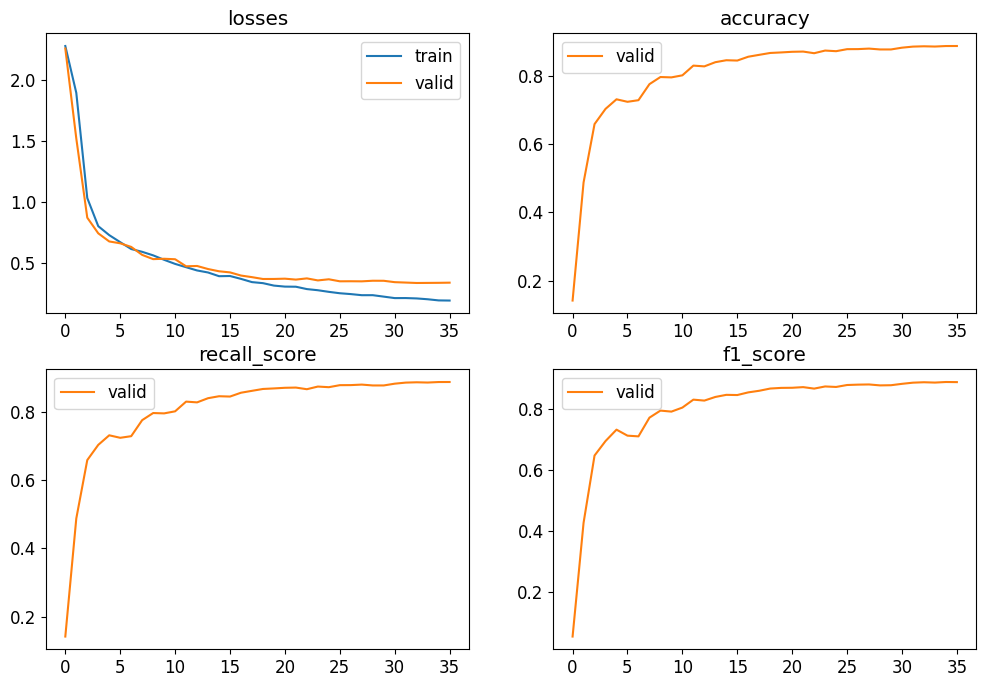

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3370
Accuracy: 0.8869
Recall: 0.8869
F1-Score: 0.8865


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster01_v4.pkl')

Example 2

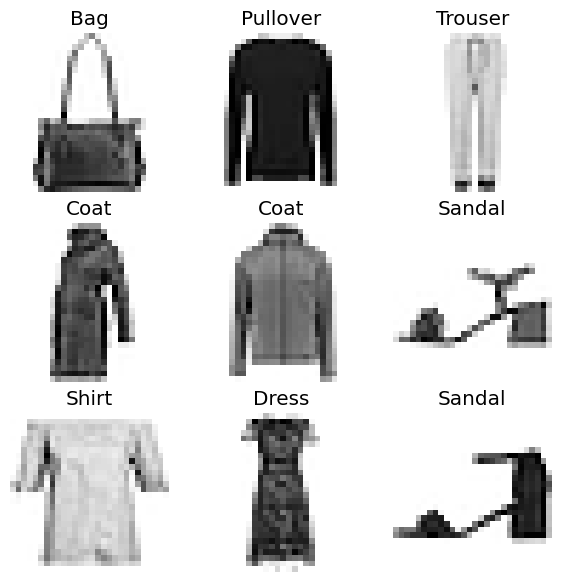

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.284567,2.270900,0.111111,0.111111,0.022222,00:16
1,2.139728,2.000728,0.405648,0.405648,0.313803,00:17
2,1.258388,0.950626,0.648426,0.648426,0.627232,00:16
3,0.849391,0.822880,0.668056,0.668056,0.642441,00:16
4,0.731128,0.688921,0.730185,0.730185,0.730374,00:15
5,0.672799,0.651580,0.737870,0.737870,0.709672,00:16
6,0.640294,0.626588,0.746481,0.746481,0.743468,00:15
7,0.587281,0.582640,0.779352,0.779352,0.774622,00:17
8,0.535006,0.554202,0.791574,0.791574,0.784803,00:16
9,0.508091,0.583563,0.789167,0.789167,0.769025,00:16


No improvement since epoch 32: early stopping

Tiempo de entrenamiento: 600.93 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3234
Accuracy: 0.8885
Recall: 0.8885
F1-Score: 0.8886


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster03_v4.pkl')

## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

eXample 1

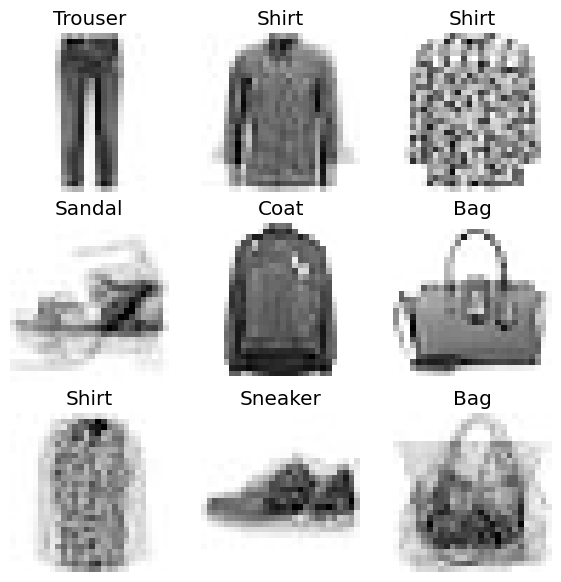

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 19440
Número total de imágenes en validación: 5400

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser']


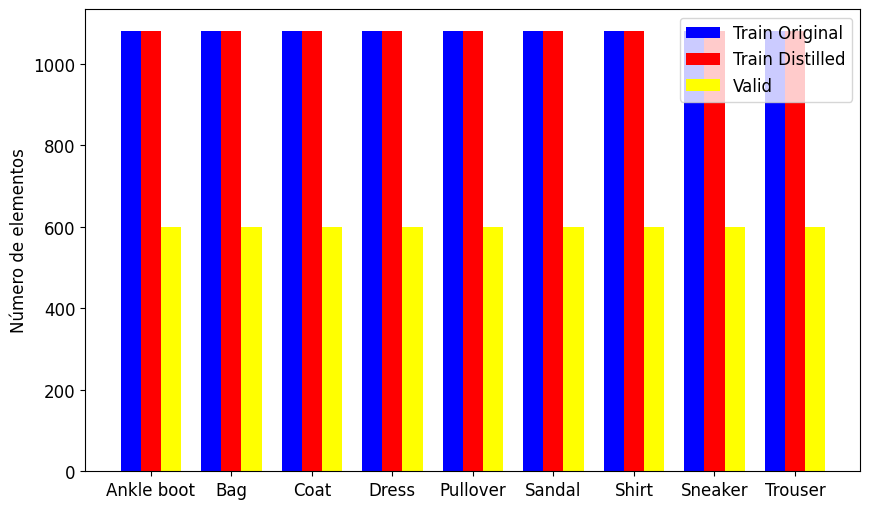

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.162219,2.062180,0.291667,0.291667,0.189212,00:20
1,0.926977,0.913464,0.643333,0.643333,0.626539,00:21
2,0.592275,0.723897,0.714815,0.714815,0.707604,00:19
3,0.515976,0.639521,0.738889,0.738889,0.739628,00:21
4,0.432953,0.631623,0.757593,0.757593,0.750925,00:20
5,0.403635,0.554336,0.782407,0.782407,0.781935,00:21
6,0.349343,0.523807,0.807037,0.807037,0.799338,00:19
7,0.328809,0.446206,0.837037,0.837037,0.834004,00:20
8,0.299082,0.431279,0.843518,0.843519,0.844607,00:20
9,0.262893,0.428119,0.842593,0.842593,0.843089,00:20


No improvement since epoch 22: early stopping

Tiempo de entrenamiento: 656.19 segundos


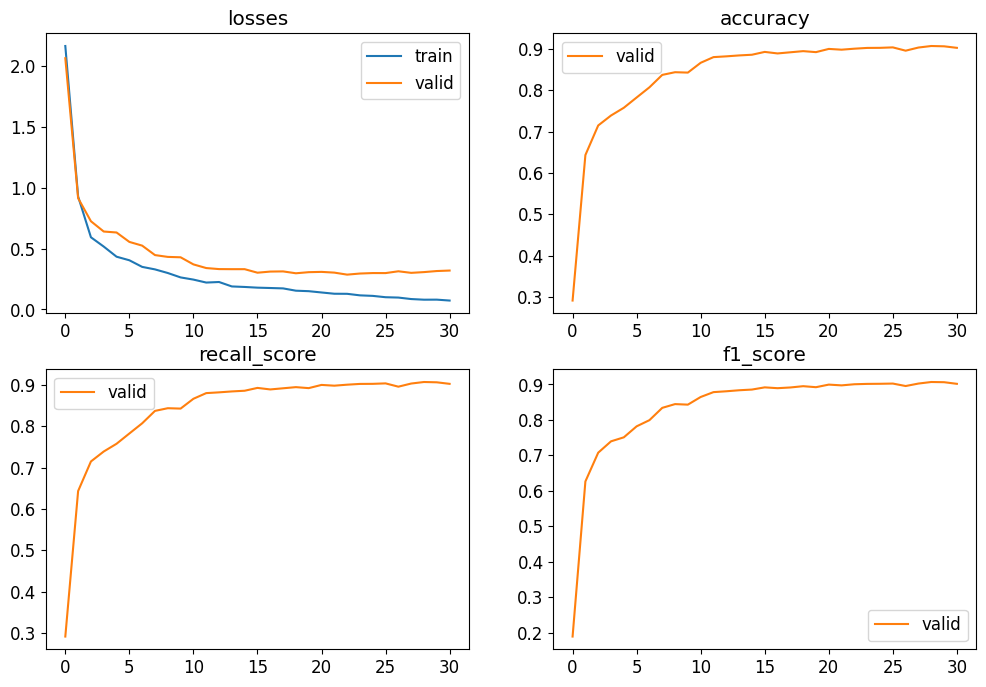

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3193
Accuracy: 0.9024
Recall: 0.9024
F1-Score: 0.9017


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster01_v4.pkl')

Example 2

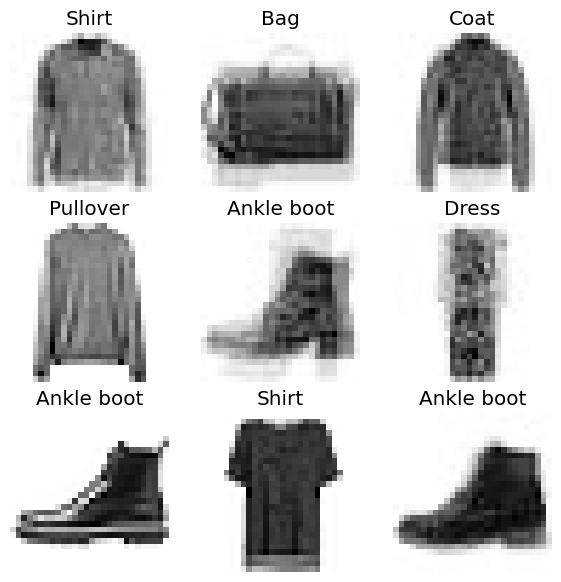

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.162358,2.055463,0.329074,0.329074,0.246802,00:19
1,0.957879,0.921825,0.643889,0.643889,0.621219,00:21
2,0.610627,0.752889,0.699444,0.699444,0.694264,00:20
3,0.536137,0.674014,0.730000,0.730000,0.725526,00:21
4,0.473438,0.589850,0.777222,0.777222,0.775961,00:19
5,0.414526,0.581348,0.780370,0.780370,0.777805,00:20
6,0.355353,0.515603,0.813333,0.813333,0.811201,00:20
7,0.348863,0.526734,0.808148,0.808148,0.803801,00:20
8,0.301745,0.485633,0.830000,0.830000,0.832136,00:21
9,0.277930,0.418317,0.854259,0.854259,0.852513,00:19


No improvement since epoch 20: early stopping

Tiempo de entrenamiento: 617.50 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3285
Accuracy: 0.8959
Recall: 0.8959
F1-Score: 0.8957


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster02_v4.pkl')

example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster03_v4.pkl')

## Resnet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

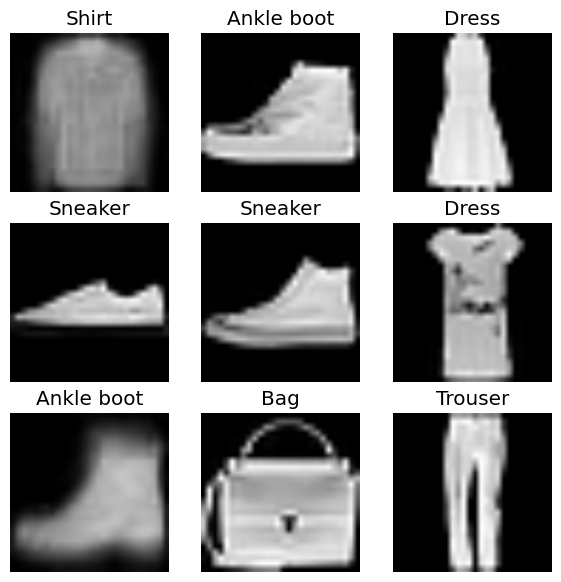

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 9558
Número total de imágenes en validación: 10800

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.089587,0.704934,0.739815,0.739815,0.738227,01:01
1,0.748675,0.729700,0.739907,0.739907,0.732283,01:00
2,0.575245,0.867891,0.722037,0.722037,0.717318,01:02
3,0.488567,0.482101,0.843241,0.843241,0.839781,01:02
4,0.413462,0.762833,0.756759,0.756759,0.751453,01:01
5,0.374455,0.358508,0.873426,0.873426,0.873197,01:01
6,0.337722,0.324541,0.884259,0.884259,0.884426,01:03
7,0.298996,0.345291,0.871481,0.871481,0.866604,01:03
8,0.264069,0.353620,0.872500,0.872500,0.870654,01:01
9,0.221652,0.408658,0.861481,0.861481,0.855944,01:02


No improvement since epoch 6: early stopping

Tiempo de entrenamiento: 621.15 segundos


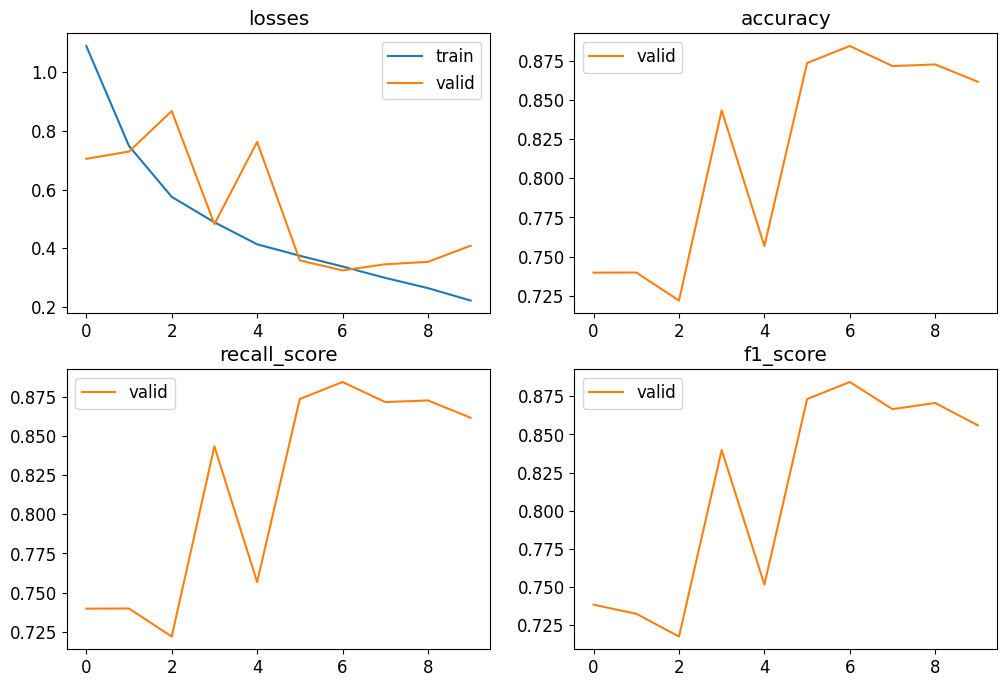

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.4087
Accuracy: 0.8615
Recall: 0.8615
F1-Score: 0.8559


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster01_v4.pkl')

Example 2

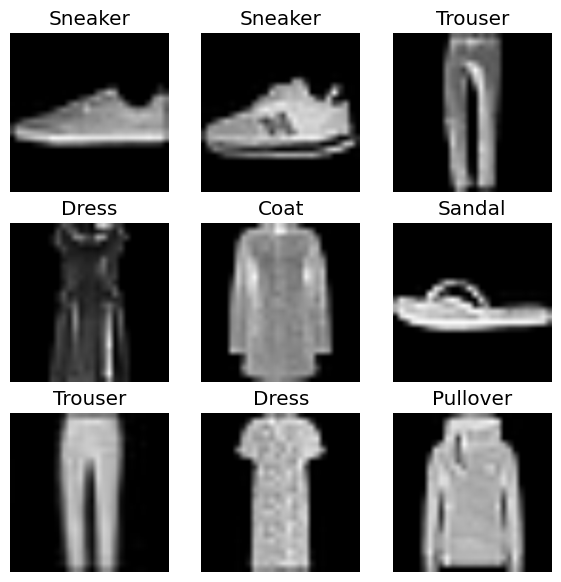

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.081131,0.747706,0.742037,0.742037,0.738778,01:07
1,0.705736,0.513551,0.814259,0.814259,0.814398,01:10
2,0.539196,0.583678,0.801481,0.801481,0.793229,01:02
3,0.462123,4.600695,0.388611,0.388611,0.357823,01:02
4,0.404399,0.451892,0.846667,0.846667,0.845253,01:03
5,0.337211,0.397833,0.858704,0.858704,0.858049,01:02
6,0.291227,0.304941,0.891667,0.891667,0.891580,01:01
7,0.257593,0.347851,0.883889,0.883889,0.884600,01:02
8,0.217877,0.284875,0.901019,0.901019,0.900643,01:03
9,0.182782,0.246498,0.914722,0.914722,0.914023,01:02


No improvement since epoch 9: early stopping

Tiempo de entrenamiento: 826.76 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2522
Accuracy: 0.9222
Recall: 0.9222
F1-Score: 0.9222


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster03_v4.pkl')

## Resnet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

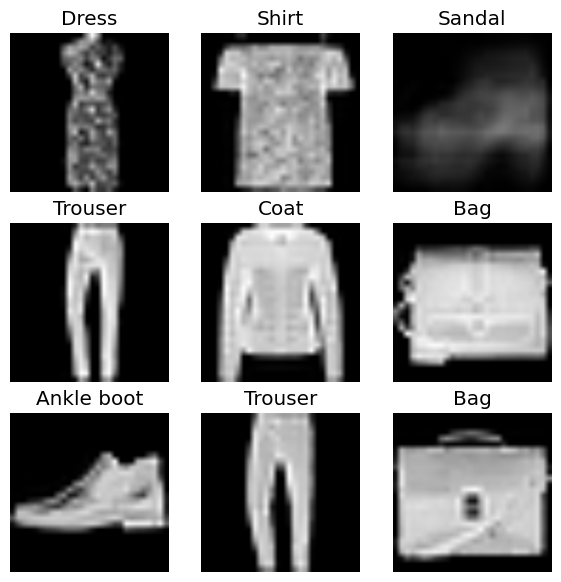

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 8820
Número total de imágenes en validación: 10800

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.185519,0.658234,0.756481,0.756481,0.751550,00:59
1,0.743961,0.693663,0.785185,0.785185,0.782196,00:58
2,0.628879,0.662202,0.796852,0.796852,0.790620,00:59
3,0.520095,0.465769,0.840093,0.840093,0.838361,00:58
4,0.467207,0.407069,0.852685,0.852685,0.851379,01:00
5,0.409782,0.403438,0.852315,0.852315,0.850811,01:00
6,0.358143,0.333047,0.877593,0.877593,0.879169,00:59
7,0.310857,0.299411,0.893889,0.893889,0.893488,01:00
8,0.295260,0.324772,0.884907,0.884907,0.883633,01:00
9,0.252956,0.273256,0.898704,0.898704,0.897334,01:00


No improvement since epoch 12: early stopping

Tiempo de entrenamiento: 955.37 segundos


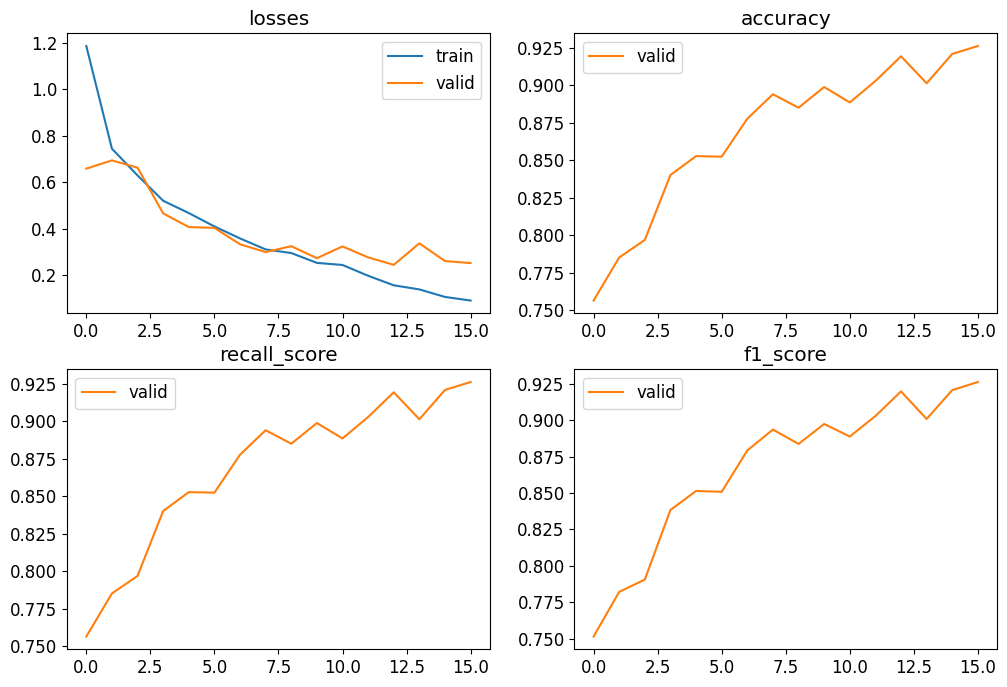

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2522
Accuracy: 0.9260
Recall: 0.9260
F1-Score: 0.9261


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster01_v4.pkl')

Example 2

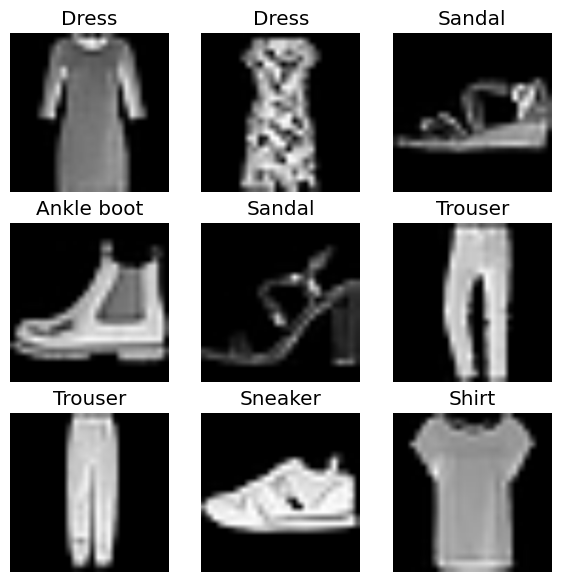

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.145217,0.881981,0.717685,0.717685,0.709379,01:01
1,0.758960,2.926626,0.422593,0.422593,0.389481,01:11
2,0.616345,0.882844,0.723704,0.723704,0.691943,01:01
3,0.451809,0.569916,0.814722,0.814722,0.811321,01:00
4,0.413801,0.460639,0.841296,0.841296,0.840444,00:59
5,0.338655,0.348977,0.879259,0.879259,0.879036,01:00
6,0.316124,0.423875,0.853981,0.853981,0.851427,00:59
7,0.274854,0.309690,0.889259,0.889259,0.887478,01:00
8,0.241863,0.263673,0.905370,0.905370,0.905445,01:01
9,0.218182,0.237002,0.916481,0.916481,0.916003,01:00


No improvement since epoch 12: early stopping

Tiempo de entrenamiento: 977.09 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2772
Accuracy: 0.9286
Recall: 0.9286
F1-Score: 0.9288


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster03_v4.pkl')

## Resnet 0001

In [ ]:
dst = base_path / "distilled_0001"

Example 1

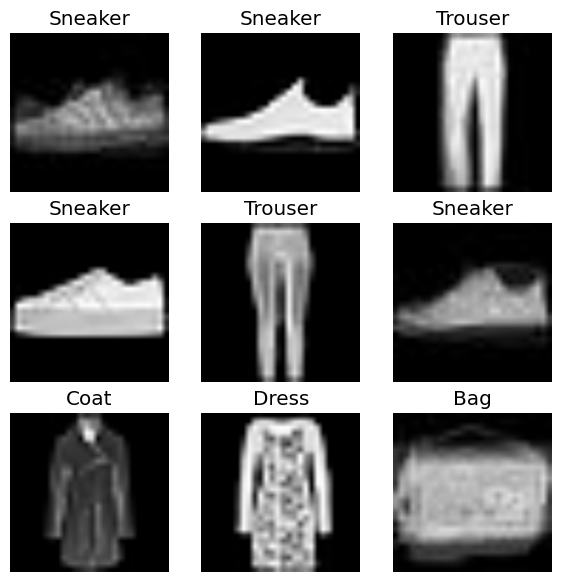

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 19440
Número total de imágenes en validación: 5400

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.586281,0.572543,0.801852,0.801852,0.802195,01:26
1,0.420661,0.485955,0.839259,0.839259,0.836308,01:23
2,0.349355,0.533166,0.821667,0.821667,0.820708,01:24
3,0.294536,0.654130,0.779815,0.779815,0.780270,01:23
4,0.246774,0.390937,0.868704,0.868704,0.870234,01:23
5,0.235571,0.458760,0.843518,0.843519,0.838335,01:23
6,0.195346,0.292104,0.895370,0.895370,0.895655,01:22
7,0.179095,0.404919,0.869815,0.869815,0.870700,01:22
8,0.162287,0.305062,0.894630,0.894630,0.895677,01:22
9,0.143515,0.238555,0.917963,0.917963,0.918092,01:22


No improvement since epoch 9: early stopping

Tiempo de entrenamiento: 1519.02 segundos


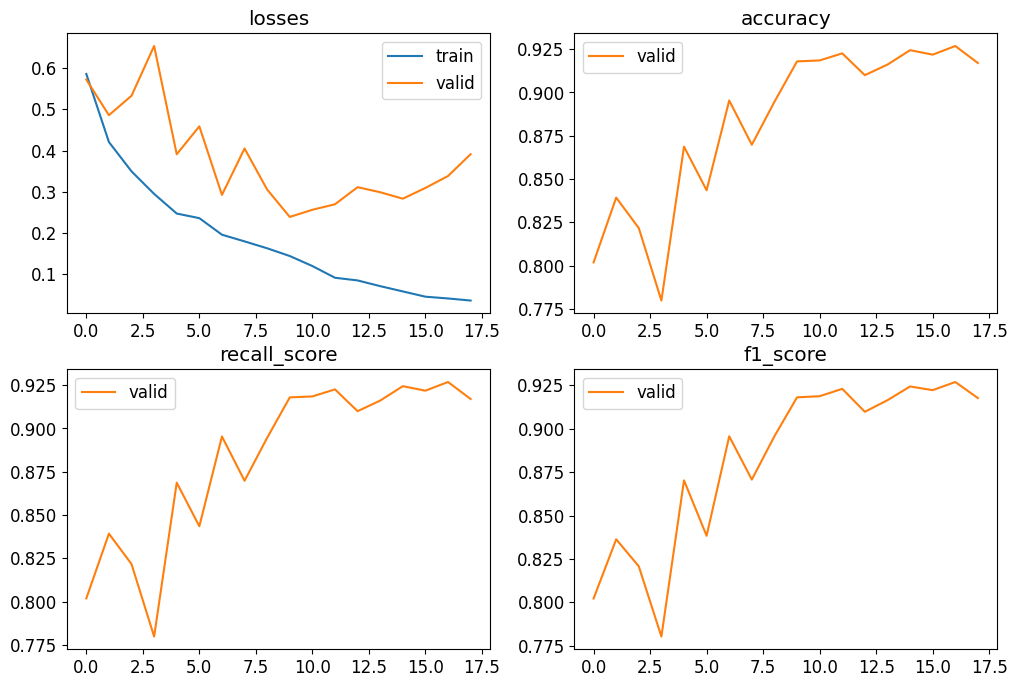

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3911
Accuracy: 0.9170
Recall: 0.9170
F1-Score: 0.9177


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster01_v4.pkl')

Example 2

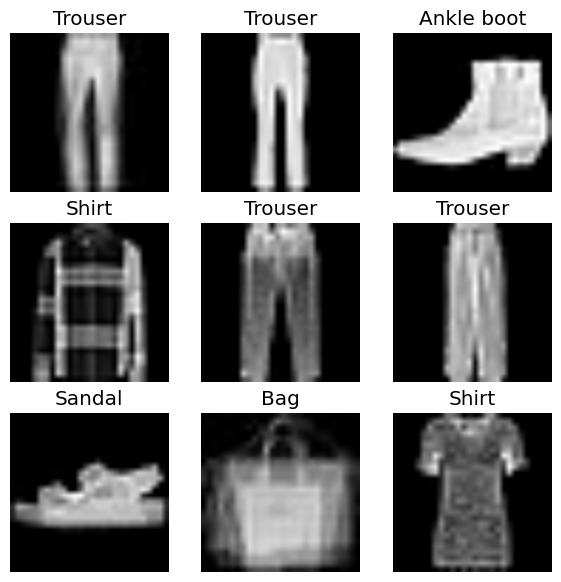

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.645930,0.753404,0.761111,0.761111,0.753592,01:24
1,0.459800,0.543759,0.815185,0.815185,0.813182,01:22
2,0.359691,0.526546,0.818333,0.818333,0.815415,01:23
3,0.292993,0.404032,0.856852,0.856852,0.856612,01:23
4,0.261104,0.366152,0.880185,0.880185,0.879643,01:23
5,0.250116,0.733334,0.774259,0.774259,0.768722,01:23
6,0.198566,0.307655,0.897778,0.897778,0.897607,01:23
7,0.168642,0.286521,0.905000,0.905000,0.905234,01:23
8,0.158339,0.385917,0.875926,0.875926,0.871067,01:22
9,0.136068,0.305422,0.898889,0.898889,0.898594,01:23


No improvement since epoch 11: early stopping

Tiempo de entrenamiento: 1666.68 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3617
Accuracy: 0.9281
Recall: 0.9281
F1-Score: 0.9282


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster03_v4.pkl')

# Apartado 4

In [ ]:
mnist_001_path = base_path / "distilled_001"
mnist_001_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path, mnist_001_path, valid_ratio=0.2, distilled_portion=0.99, group_fraction=0.01, mix_function=media_arit)


In [ ]:
mnist_005_path = base_path / "distilled_005"
mnist_005_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path, mnist_005_path, valid_ratio=0.2, distilled_portion=0.99, group_fraction=0.05, mix_function=media_arit)

In [ ]:
mnist_0001_path = base_path / "distilled_0001"
mnist_0001_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path, mnist_0001_path, valid_ratio=0.2, distilled_portion=0.99, group_fraction=0.001, mix_function=media_arit)

## Lenet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

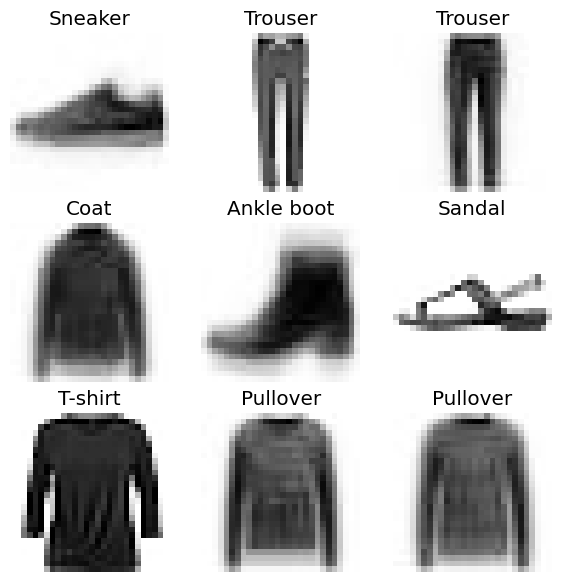

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 1500
Número total de imágenes en validación: 12000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


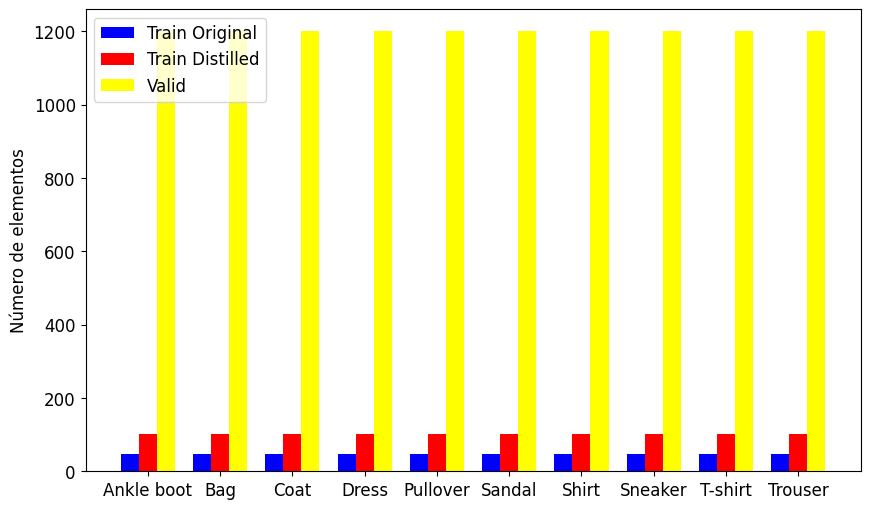

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.300395,2.297943,0.117750,0.117750,0.054119,00:11
1,2.292689,2.266742,0.354167,0.354167,0.243635,00:11
2,2.207368,1.788535,0.375500,0.375500,0.235066,00:10
3,1.742024,1.104662,0.549417,0.549417,0.481514,00:10
4,1.304862,0.961026,0.631000,0.631000,0.620592,00:10
5,1.015840,0.891958,0.679500,0.679500,0.678934,00:10
6,0.821637,0.919658,0.692000,0.692000,0.688966,00:10
7,0.694621,0.884463,0.680333,0.680333,0.677513,00:09
8,0.607446,0.947251,0.674583,0.674583,0.667633,00:10
9,0.554721,0.907985,0.675583,0.675583,0.669975,00:10



Tiempo de entrenamiento: 213.01 segundos


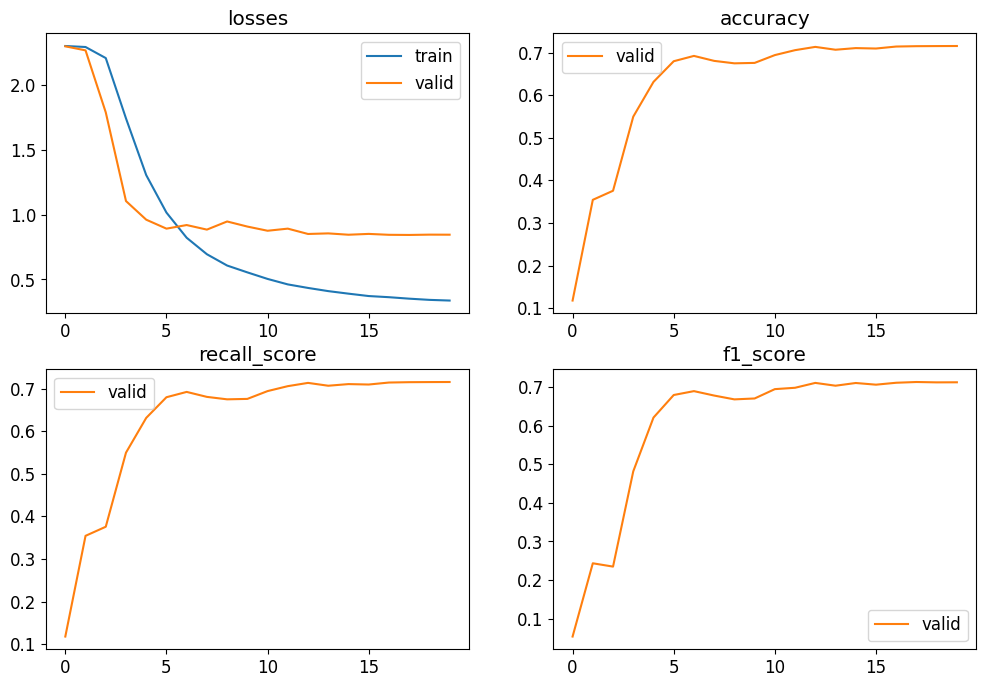

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.8453
Accuracy: 0.7153
Recall: 0.7153
F1-Score: 0.7118


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_99cluster01_v4.pkl')

Example 2

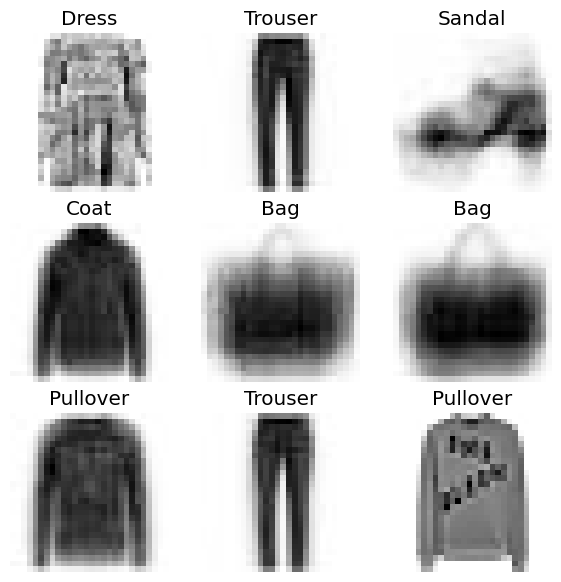

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.302557,2.299632,0.100000,0.100000,0.018182,00:10
1,2.296167,2.277966,0.137417,0.137417,0.078273,00:10
2,2.241012,1.956176,0.469417,0.469417,0.410863,00:10
3,1.843761,1.138871,0.546917,0.546917,0.505358,00:09
4,1.398312,1.214256,0.544417,0.544417,0.518595,00:10
5,1.101245,0.990597,0.660417,0.660417,0.648860,00:10
6,0.909037,0.984984,0.646750,0.646750,0.637798,00:10
7,0.771182,0.984911,0.658917,0.658917,0.631699,00:09
8,0.678456,1.000902,0.653250,0.653250,0.636848,00:10
9,0.612981,0.926942,0.670667,0.670667,0.669815,00:10


No improvement since epoch 15: early stopping

Tiempo de entrenamiento: 199.21 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9060
Accuracy: 0.6959
Recall: 0.6959
F1-Score: 0.6941


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_99cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_99cluster03_v4.pkl')

## Lenet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

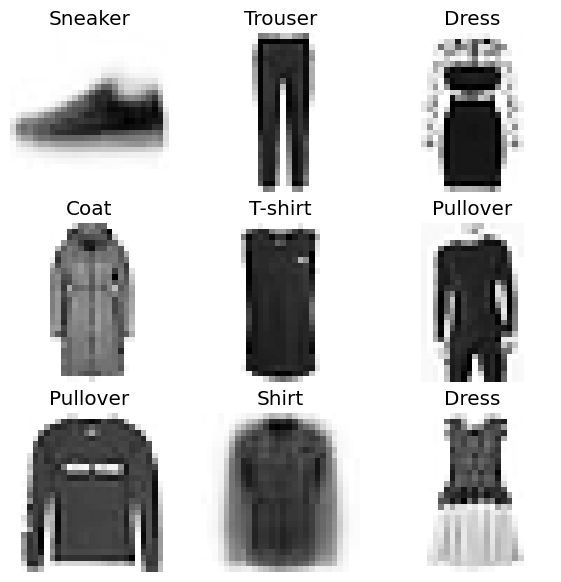

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 690
Número total de imágenes en validación: 12000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


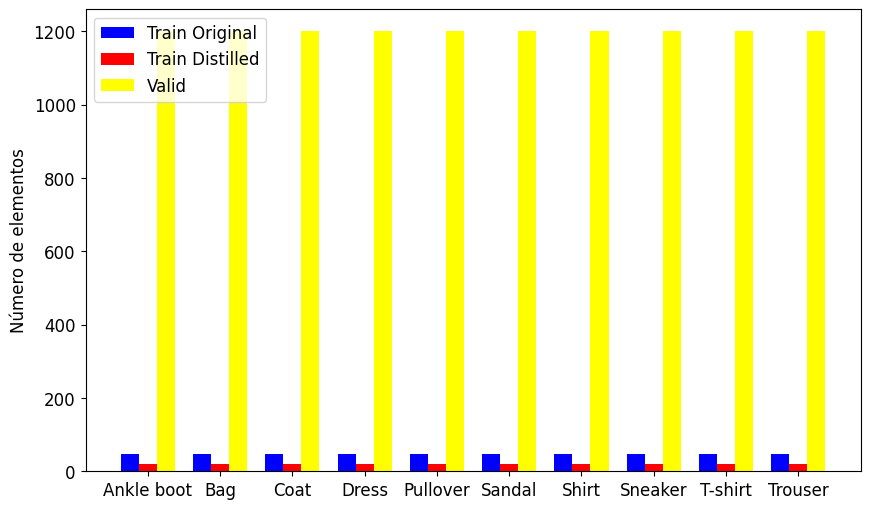

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.304628,2.303380,0.070583,0.070583,0.018413,00:10
1,2.303094,2.298222,0.135750,0.135750,0.043402,00:16
2,2.298573,2.278677,0.234833,0.234833,0.147950,00:14
3,2.278278,2.150728,0.302167,0.302167,0.239410,00:14
4,2.179585,1.633390,0.414250,0.414250,0.340487,00:12
5,1.957268,1.183244,0.503917,0.503917,0.446918,00:08
6,1.721532,1.051049,0.593250,0.593250,0.573868,00:08
7,1.520806,0.996662,0.617417,0.617417,0.595383,00:09
8,1.353785,0.944627,0.633417,0.633417,0.619863,00:09
9,1.216829,0.939106,0.649083,0.649083,0.641761,00:08



Tiempo de entrenamiento: 208.69 segundos


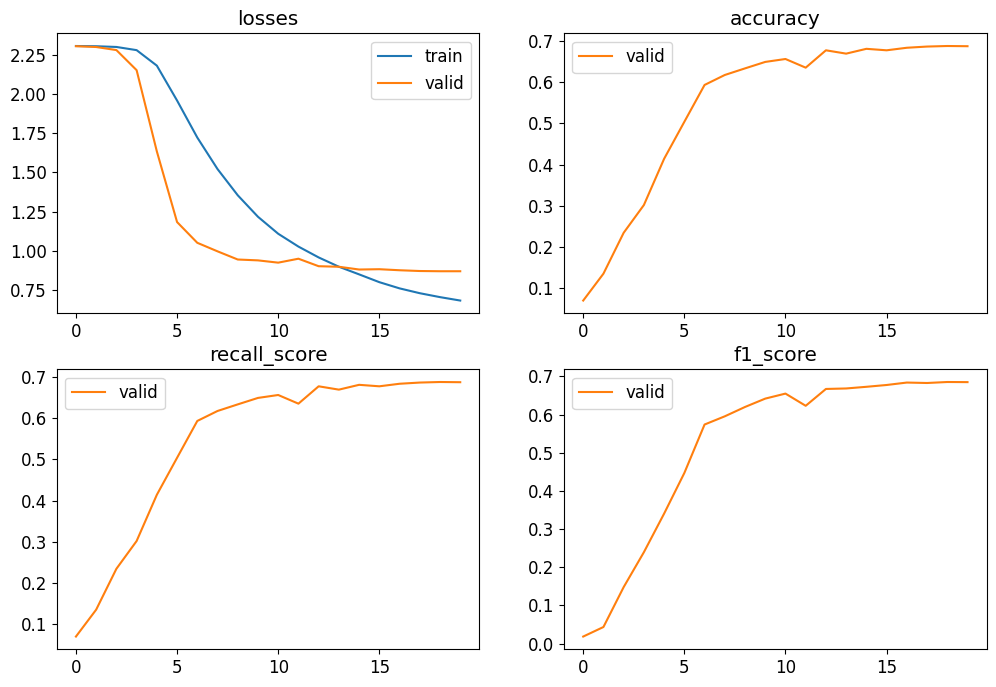

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.8698
Accuracy: 0.6872
Recall: 0.6872
F1-Score: 0.6849


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_99cluster01_v4.pkl')

Example 2

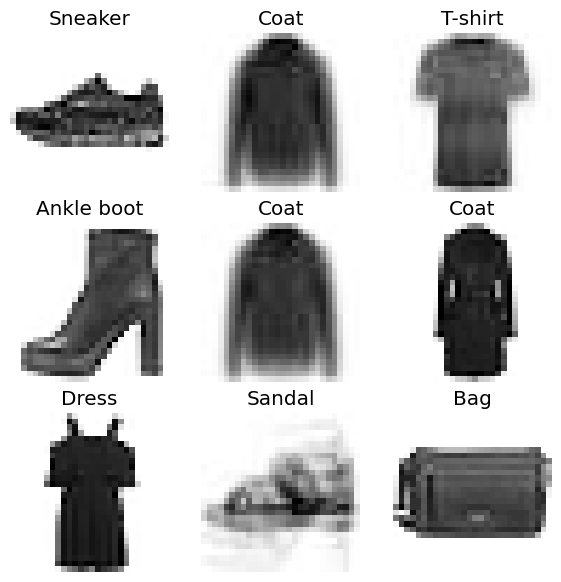

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.303129,2.302255,0.100000,0.100000,0.018182,00:10
1,2.301224,2.296947,0.105750,0.105750,0.028558,00:08
2,2.297199,2.277831,0.272833,0.272833,0.161522,00:09
3,2.276393,2.130002,0.375667,0.375667,0.305948,00:09
4,2.158689,1.511076,0.477167,0.477167,0.404374,00:08
5,1.936304,1.232343,0.538583,0.538583,0.474966,00:10
6,1.738415,1.120883,0.535750,0.535750,0.462869,00:09
7,1.570855,1.120024,0.591250,0.591250,0.545899,00:08
8,1.425580,1.011321,0.616250,0.616250,0.593379,00:09
9,1.302351,1.008313,0.635167,0.635167,0.611997,00:09


No improvement since epoch 16: early stopping

Tiempo de entrenamiento: 191.70 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.9102
Accuracy: 0.6711
Recall: 0.6711
F1-Score: 0.6699


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_99cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_99cluster03_v4.pkl')

## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

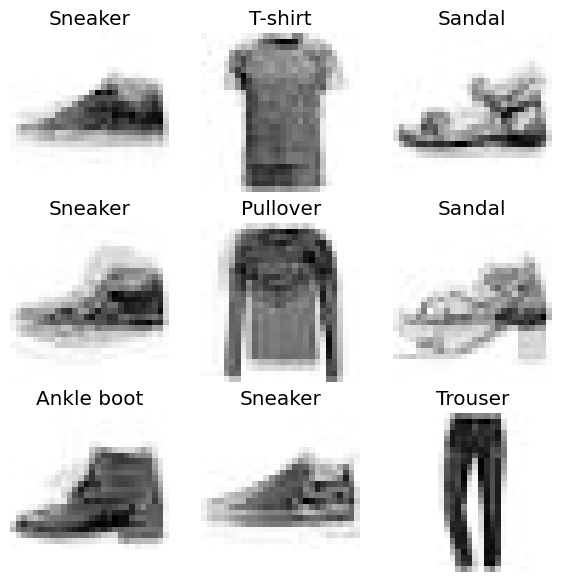

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 12360
Número total de imágenes en validación: 12000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


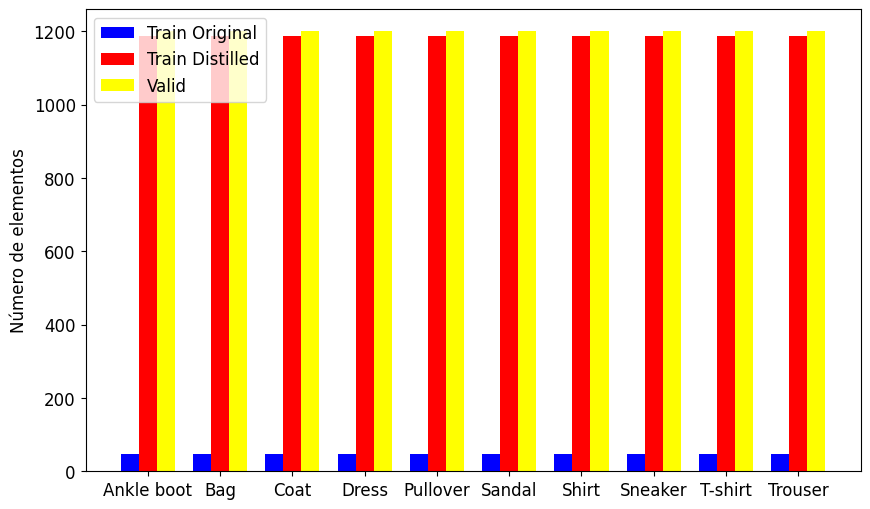

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.281000,2.264239,0.197750,0.197750,0.108526,00:19
1,1.731301,1.432136,0.515417,0.515417,0.484049,00:19
2,0.674383,1.064497,0.628167,0.628167,0.614679,00:17
3,0.439743,1.145188,0.652917,0.652917,0.648637,00:17
4,0.335486,1.157728,0.688417,0.688417,0.679789,00:19
5,0.292393,1.061780,0.707167,0.707167,0.702975,00:17
6,0.263107,1.129288,0.696667,0.696667,0.696486,00:17
7,0.237920,1.041314,0.729500,0.729500,0.728305,00:19
8,0.223497,1.055092,0.723417,0.723417,0.714874,00:17
9,0.209773,0.949243,0.739583,0.739583,0.739129,00:17


No improvement since epoch 14: early stopping

Tiempo de entrenamiento: 328.71 segundos


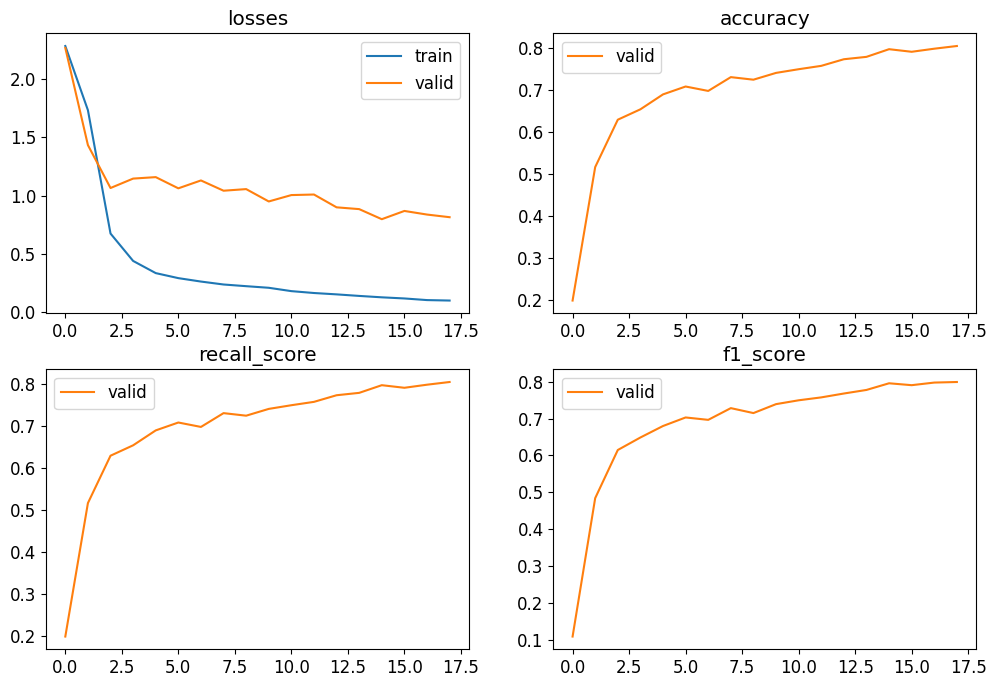

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.8144
Accuracy: 0.8036
Recall: 0.8036
F1-Score: 0.7992


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_99cluster01_v4.pkl')

Exampel 2

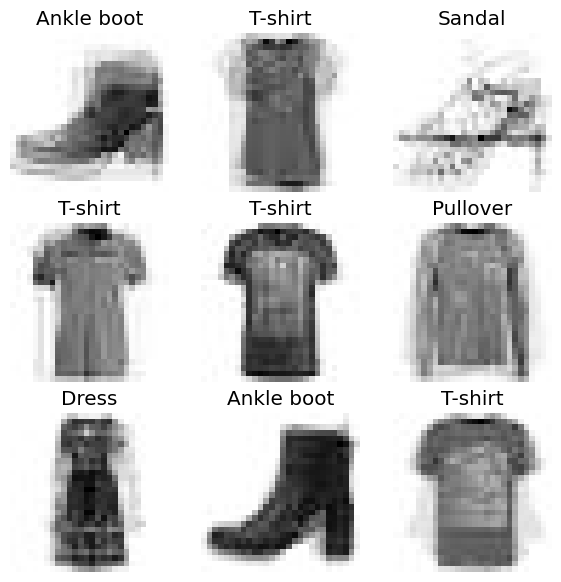

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.287860,2.272570,0.223833,0.223833,0.124573,00:18
1,1.834922,1.533939,0.476833,0.476833,0.388938,00:17
2,0.729451,1.058456,0.625083,0.625083,0.612579,00:18
3,0.477872,1.139305,0.654583,0.654583,0.641720,00:18
4,0.370796,1.153279,0.668333,0.668333,0.658986,00:17
5,0.321791,1.005245,0.704917,0.704917,0.705838,00:18
6,0.278489,0.942777,0.732333,0.732333,0.730003,00:18
7,0.222279,1.034249,0.723083,0.723083,0.723317,00:17
8,0.234509,0.952456,0.729667,0.729667,0.729382,00:18
9,0.187097,1.040200,0.742500,0.742500,0.742795,00:18


No improvement since epoch 6: early stopping

Tiempo de entrenamiento: 182.70 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.0402
Accuracy: 0.7425
Recall: 0.7425
F1-Score: 0.7428


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_99cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_99cluster03_v4.pkl')

## Resnet 001

In [ ]:
dst = base_path / "distilled_001"

Example 1

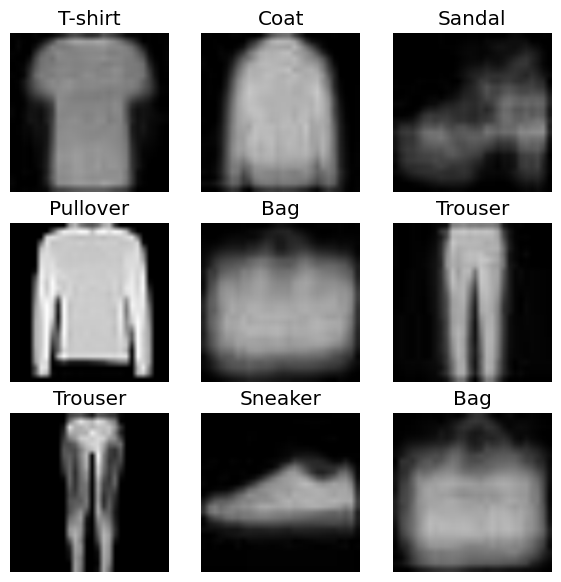

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 1500
Número total de imágenes en validación: 12000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.709949,4.056382,0.114333,0.114333,0.037281,00:30
1,1.077259,4.209625,0.216167,0.216167,0.130330,00:31
2,0.851607,12.789654,0.184583,0.184583,0.101841,00:29
3,0.707599,4.030420,0.337583,0.337583,0.280630,00:30
4,0.576831,1.107079,0.685500,0.685500,0.671790,00:33
5,0.481328,1.080944,0.689500,0.689500,0.675800,00:30
6,0.395465,1.203941,0.642250,0.642250,0.637644,00:29
7,0.314755,0.962758,0.742333,0.742333,0.738640,00:30
8,0.249943,0.846553,0.752250,0.752250,0.761237,00:30
9,0.194634,0.834924,0.758250,0.758250,0.758120,00:30


No improvement since epoch 10: early stopping

Tiempo de entrenamiento: 430.67 segundos


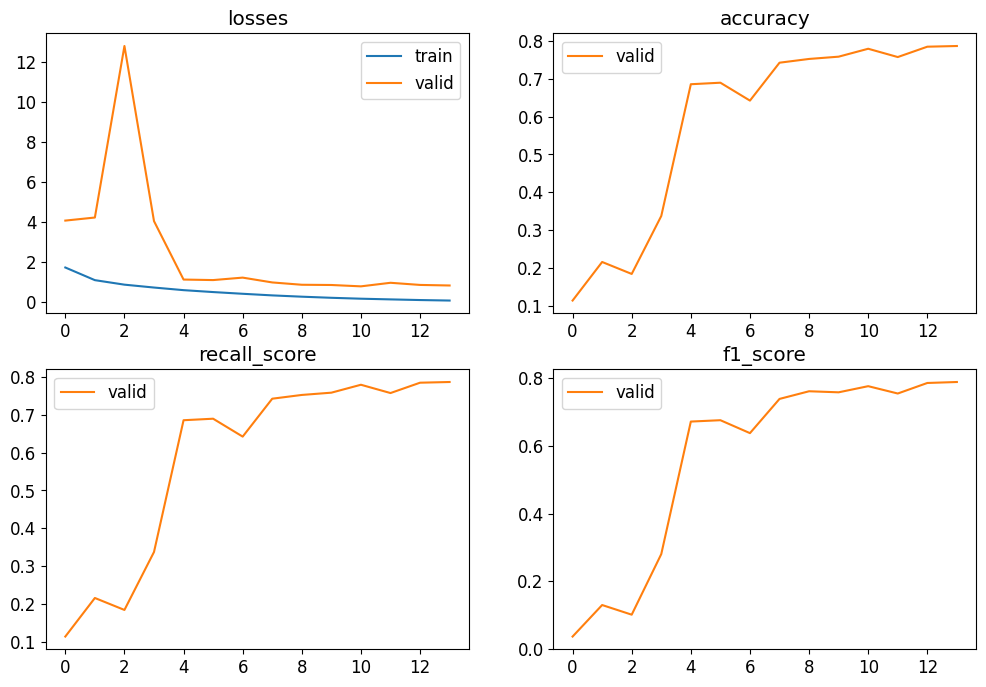

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.8102
Accuracy: 0.7864
Recall: 0.7864
F1-Score: 0.7886


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_99cluster01_v4.pkl')

Exaple 2

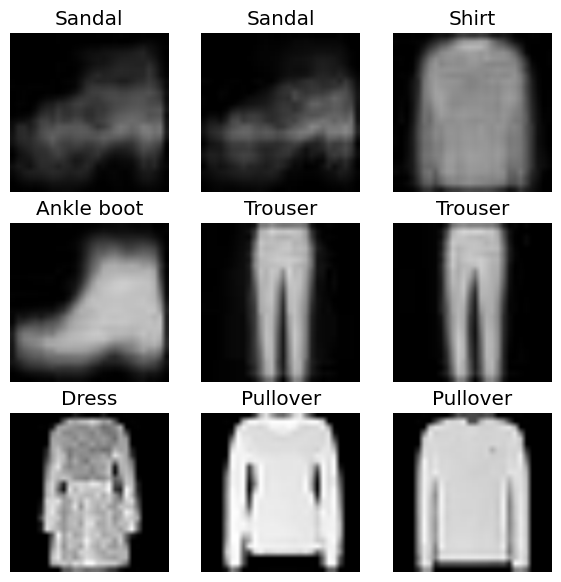

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.719427,3.939842,0.164000,0.164000,0.076582,00:31
1,1.117487,3.628296,0.165583,0.165583,0.091692,00:30
2,0.851817,3.975684,0.275417,0.275417,0.217300,00:30
3,0.697856,1.302840,0.610250,0.610250,0.580429,00:31
4,0.575246,2.340721,0.507500,0.507500,0.488281,00:30
5,0.472650,2.265246,0.463833,0.463833,0.403051,00:31
6,0.387088,1.050705,0.708750,0.708750,0.692496,00:30
7,0.310361,0.982508,0.722333,0.722333,0.713822,00:30
8,0.238515,1.024681,0.721083,0.721083,0.723051,00:31
9,0.185426,1.008891,0.732750,0.732750,0.727088,00:31


No improvement since epoch 7: early stopping

Tiempo de entrenamiento: 338.91 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.0522
Accuracy: 0.7421
Recall: 0.7421
F1-Score: 0.7389


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_99cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_99cluster03_v4.pkl')

## Resnet 005

In [ ]:
dst = base_path / "distilled_005"

Example 1

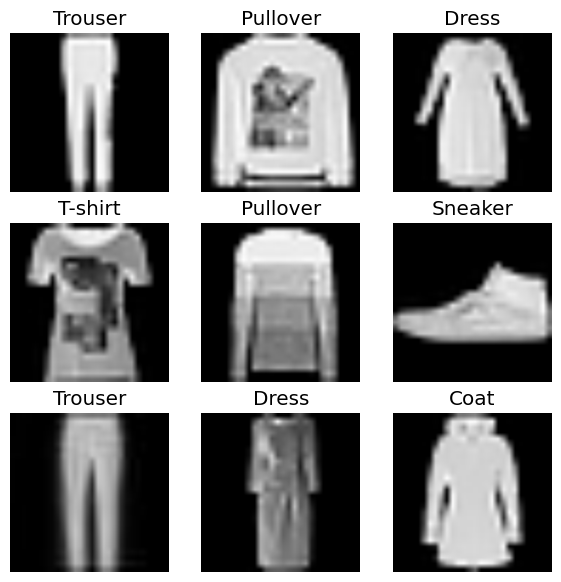

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 690
Número total de imágenes en validación: 12000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.686669,2.770725,0.104000,0.104000,0.025098,00:28
1,1.986487,3.998926,0.131250,0.131250,0.041441,00:27
2,1.564257,4.630682,0.164167,0.164167,0.086610,00:28
3,1.334609,3.808388,0.235917,0.235917,0.176579,00:27


No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 111.78 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 3.8084
Accuracy: 0.2359
Recall: 0.2359
F1-Score: 0.1766


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_99cluster01_v4.pkl')

Example 2

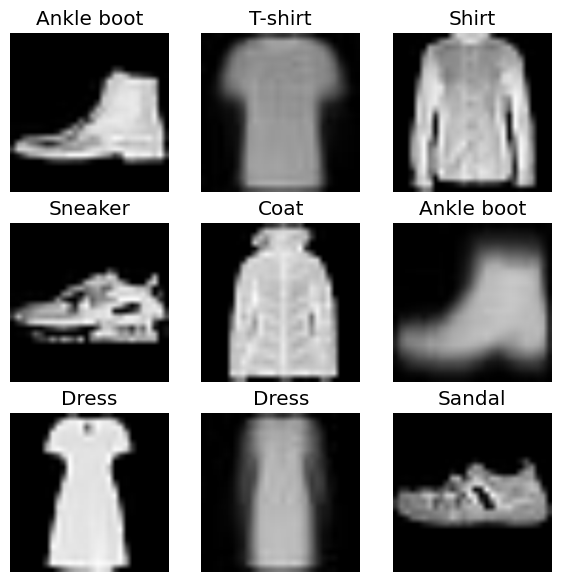

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.859209,2.597741,0.113500,0.113500,0.034962,00:27
1,2.124091,3.231018,0.162167,0.162167,0.109310,00:27
2,1.673407,6.031249,0.102167,0.102167,0.022596,00:28
3,1.390863,3.456531,0.156167,0.156167,0.095001,00:28


No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 111.48 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 3.4565
Accuracy: 0.1562
Recall: 0.1562
F1-Score: 0.0950


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_99cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_99cluster03_v4.pkl')

## Resnet 0001

In [ ]:
dst = base_path / "distilled_0001"

Example 1

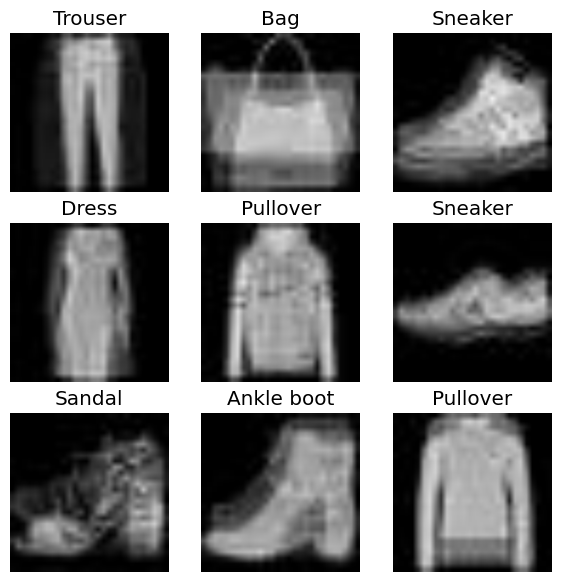

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

Número total de imágenes en entrenamiento: 12360
Número total de imágenes en validación: 12000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.462588,1.521955,0.583167,0.583167,0.558759,01:10
1,0.257910,1.299885,0.658250,0.658250,0.638646,01:10
2,0.220958,1.679813,0.577000,0.577000,0.546070,01:10
3,0.194374,0.898619,0.755917,0.755917,0.752234,01:10
4,0.180210,4.248981,0.387833,0.387833,0.323921,01:10
5,0.167509,1.111736,0.690417,0.690417,0.682929,01:10
6,0.155544,0.977978,0.746167,0.746167,0.749835,01:10
7,0.132760,1.599086,0.571583,0.571583,0.523680,01:09
8,0.105324,0.611749,0.813500,0.813500,0.810412,01:09
9,0.102980,0.659401,0.817917,0.817917,0.818904,01:09


No improvement since epoch 11: early stopping

Tiempo de entrenamiento: 1398.36 segundos


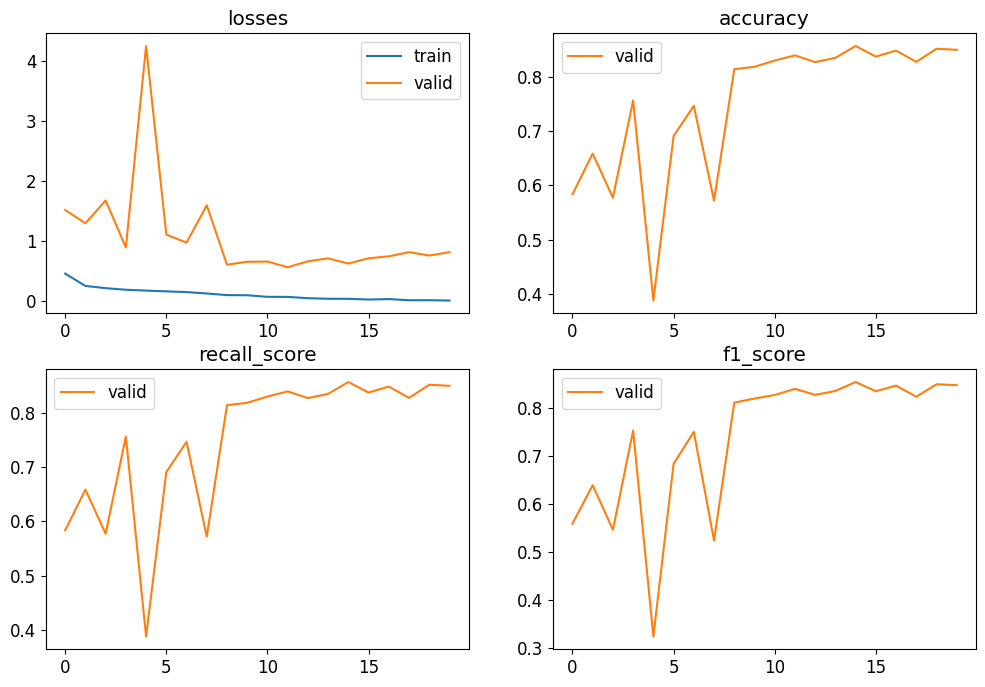

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.8195
Accuracy: 0.8492
Recall: 0.8492
F1-Score: 0.8467


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_99cluster01_v4.pkl')

Example 2

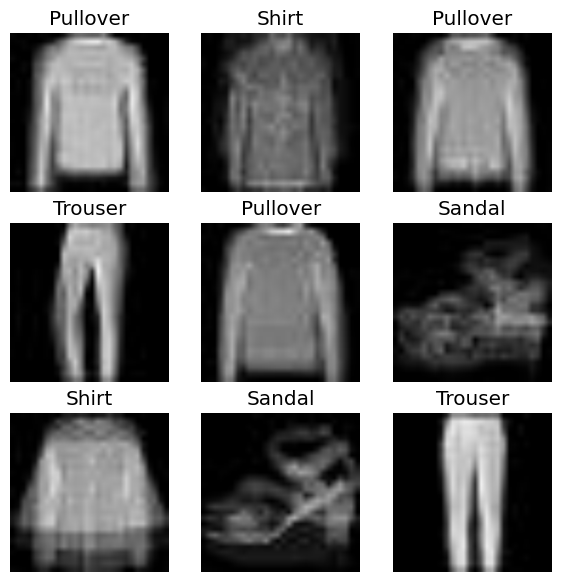

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.491549,1.197285,0.644750,0.644750,0.627233,01:10
1,0.269683,1.213985,0.664583,0.664583,0.649479,01:10
2,0.240585,1.011671,0.725667,0.725667,0.722673,01:10
3,0.198777,0.938409,0.761667,0.761667,0.760764,01:10
4,0.169171,1.471479,0.582417,0.582417,0.572007,01:09
5,0.155428,0.737993,0.798500,0.798500,0.795879,01:09
6,0.148434,0.638370,0.811167,0.811167,0.811543,01:09
7,0.122136,1.159713,0.698000,0.698000,0.692027,01:09
8,0.119568,0.645711,0.822083,0.822083,0.819317,01:09
9,0.098049,0.711468,0.810750,0.810750,0.809427,01:10


No improvement since epoch 11: early stopping

Tiempo de entrenamiento: 1409.28 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.7535
Accuracy: 0.8524
Recall: 0.8524
F1-Score: 0.8509


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_99cluster02_v4.pkl')

Example 3

In [ ]:
#random.seed(42)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
# Crear el objeto learn
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=8)])

start_time = time.time()
learn.fit_one_cycle(40)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_99cluster03_v3.pkl')

# TEST

In [8]:
test_path = Path('/content/dataset/original/fashion_mnist/test')

## Lenet original

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_original_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path, bs=64)

In [ ]:
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.2917487323284149
Accuracy: 0.8996394276618958
Recall (macro): 0.8997027154412004
F1 Score (macro): 0.8994298715505769


## Resnet18 original

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_original_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=RandomSplitter(valid_pct=0.0)
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')


Loss: 0.2595
Accuracy: 0.9329
Recall: 0.9329
F1-Score: 0.9328


## Distilled 001 & 5 cluster - Lenet

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path, bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.697462320327759
Accuracy: 0.7951722741127014
Recall (macro): 0.7951506882140178
F1 Score (macro): 0.764909956146318


 Distilled 001 & 5 cluster - Lenet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster02_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.527174711227417
Accuracy: 0.7709335088729858
Recall (macro): 0.771021393623966
F1 Score (macro): 0.7438872391002582


Distilled 001 & 5 cluster - Lenet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_5cluster03_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

## Distilled 005 & 5 cluster - Lenet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path, bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.896911144256592
Accuracy: 0.7926682829856873
Recall (macro): 0.7928518956942241
F1 Score (macro): 0.7632937721069565


Distilled 005 & 5 cluster - Lenet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster02_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.7471907138824463
Accuracy: 0.7946714758872986
Recall (macro): 0.7948400649794821
F1 Score (macro): 0.7659784718839756


Distilled 005 & 5 cluster - Lenet Ex3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_5cluster03_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

## Distilled 0001 & 5 cluster - Lenet


In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path, bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.2266321182250977
Accuracy: 0.8022836446762085
Recall (macro): 0.8023671677037155
F1 Score (macro): 0.7699625660590806


Distilled 0001 & 5 cluster - Lenet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster02_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.7828307151794434
Accuracy: 0.7958734035491943
Recall (macro): 0.7960755340317938
F1 Score (macro): 0.7638872171079832


Distilled 0001 & 5 cluster - Lenet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_5cluster03_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

## Distilled 001 & 5 cluster - Resnet




In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    splitter=RandomSplitter(valid_pct=0.0)
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
print(learn.dls.vocab)

['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser']


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

 Distilled 001 & 5 cluster - Resnet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster02_v4.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

 Distilled 001 & 5 cluster - Resnet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_5cluster03_v4.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 5.036006450653076
Accuracy: 0.18709935247898102
Recall (macro): 0.18693980834783647
F1 Score (macro): 0.09585170659564239


## Distilled 005 & 5 cluster - Resnet


In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.0, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

test_dls = dblock.dataloaders(test_path)


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster01_v4.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.77801775932312
Accuracy: 0.16796875
Recall (macro): 0.1679555330881984
F1 Score (macro): 0.05989933288465166


Distilled 005 & 5 cluster - Resnet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster02_v4.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.120920181274414
Accuracy: 0.16025641560554504
Recall (macro): 0.1603850630046452
F1 Score (macro): 0.053669887603175134


Distilled 005 & 5 cluster - Resnet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_5cluster03_v4.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.9487147331237793
Accuracy: 0.10046073794364929
Recall (macro): 0.10029999999999999
F1 Score (macro): 0.018812545809476118


## Distilled 0001 & 5 cluster - Resnet


In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.0, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

test_dls = dblock.dataloaders(test_path)


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster01_v4.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.357991695404053
Accuracy: 0.6207932829856873
Recall (macro): 0.6210106240829859
F1 Score (macro): 0.6118249192592209


Distilled 0001 & 5 cluster - Resnet Ex2


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster02_v4.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.919276237487793
Accuracy: 0.624098539352417
Recall (macro): 0.6241633469492591
F1 Score (macro): 0.6226637097886026


Distilled 0001 & 5 cluster - Resnet Ex3


In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_5cluster03_v4.pkl')


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.353611469268799
Accuracy: 0.6227964758872986
Recall (macro): 0.6226944119125661
F1 Score (macro): 0.6292651504582911


## Distilled 001 & 2 cluster - Lenet

In [9]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [10]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_99cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [11]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.4440293312072754
Accuracy: 0.5462740659713745
Recall (macro): 0.54632555194636
F1 Score (macro): 0.5473629982999794


Distilled 001 & 2 cluster - Lenet Ex 2

In [12]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_99cluster02_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [13]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.4490325450897217
Accuracy: 0.5338541865348816
Recall (macro): 0.5337789828020586
F1 Score (macro): 0.5355118552927168


Distilled 001 & 2 cluster - Lenet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_001_2cluster03_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

## Distilled 005 & 2 cluster - Lenet

In [14]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [15]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_99cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [16]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.8764572143554688
Accuracy: 0.5335536599159241
Recall (macro): 0.5334545214185729
F1 Score (macro): 0.5335201888226085


Distilled 005 & 2 cluster - Lenet Ex 2

In [17]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_99cluster02_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [18]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.0060369968414307
Accuracy: 0.5080128312110901
Recall (macro): 0.5079862458245608
F1 Score (macro): 0.5133437390726061


Distilled 005 & 2 cluster - Lenet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_005_99cluster03_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

## Distilled 0001 & 2 cluster - Lenet


In [19]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [20]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_99cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [21]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 5.154694557189941
Accuracy: 0.6173878312110901
Recall (macro): 0.6172699652801016
F1 Score (macro): 0.6253373588340521


Distilled 0001 & 2 cluster - Lenet Ex 2

In [22]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_99cluster01_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [23]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 5.16022253036499
Accuracy: 0.6173878312110901
Recall (macro): 0.6174452139421709
F1 Score (macro): 0.6254771578260632


Distilled 0001 & 2 cluster - Lenet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled_0001_99cluster03_v4.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

## Distilled 001 & 2 cluster - Resnet


In [24]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.0, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

test_dls = dblock.dataloaders(test_path)


In [25]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_99cluster01_v4.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [26]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.9251174926757812
Accuracy: 0.6282051205635071
Recall (macro): 0.6279280281604209
F1 Score (macro): 0.6239428111115507


Distilled 001 & 2 cluster - Resnet Ex 2

In [27]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_99cluster02_v4.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [28]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.7294490337371826
Accuracy: 0.5701121687889099
Recall (macro): 0.570092567270895
F1 Score (macro): 0.5791192596568334


Distilled 001 & 2 cluster - Resnet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_001_99cluster03_v4.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

## Distilled 005 & 2 cluster - Resnet


In [29]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.0, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

test_dls = dblock.dataloaders(test_path)


In [30]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_99cluster01_v4.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [31]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.0860419273376465
Accuracy: 0.1846955120563507
Recall (macro): 0.18464055438807347
F1 Score (macro): 0.11400711660633163


Distilled 005 & 2 cluster - Resnet Ex 2

In [32]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_99cluster02_v4.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [33]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.760221004486084
Accuracy: 0.15184295177459717
Recall (macro): 0.15170450931954177
F1 Score (macro): 0.0868352648147167


Distilled 005 & 2 cluster - Resnet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_005_2cluster03_v3.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

## Distilled 0001 & 2 cluster - Resnet


In [34]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.0, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

test_dls = dblock.dataloaders(test_path)


In [35]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_99cluster01_v4.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [36]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.353155612945557
Accuracy: 0.6667668223381042
Recall (macro): 0.6665578407457784
F1 Score (macro): 0.6614766811295346


Distilled 0001 & 2 cluster - Resnet Ex 2


In [37]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_99cluster02_v4.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [38]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.103922367095947
Accuracy: 0.6741786599159241
Recall (macro): 0.6742806757704736
F1 Score (macro): 0.6724617404504039


Distilled 0001 & 2 cluster - Resnet Ex 3

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled_0001_99cluster03_v4.pkl')

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")